# Tombo: Extracting and Plotting Stats from 16S rRNA

## Sample Comparison statistics

### Compute per position KS-tests

$F_{n}(x)={1 \over n}\sum _{i=1}^{n}I_{[-\infty ,x]}(X_{i})$  
$D_{n}=\sup _{x}|F_{n}(x)-F(x)|$

* Code used to generate KS tests for each position
    * note: return_stat = True
    
```
def compute_ks_tests(samp_base_levels, ctrl_base_levels, return_stat):
    def compute_pos_ks_test(pos_samp_levels, pos_ctrl_levels):
        """Compute effect size statistic or p-value of two-sample
        Kolmogorov-Smirnov test

        Using definition from
        https://github.com/scipy/scipy/blob/v0.14.0/scipy/stats/stats.py#L3886
        """
        samp_n, ctrl_n = pos_samp_levels.shape[0], pos_ctrl_levels.shape[0]
        pos_all_levels = np.concatenate([pos_samp_levels, pos_ctrl_levels])
        samp_cdf = np.searchsorted(
            pos_samp_levels, pos_all_levels, side='right') / samp_n
        ctrl_cdf = np.searchsorted(
            pos_ctrl_levels, pos_all_levels, side='right') / ctrl_n
        d = np.max(np.absolute(samp_cdf - ctrl_cdf))
        if return_stat:
            # subtract 1 so most significant are smallest values
            return 1 - d
        en = np.sqrt(samp_n * ctrl_n / float(samp_n + ctrl_n))
        return stats.distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)


    samp_valid_indices = np.logical_not(np.isnan(samp_base_levels))
    ctrl_valid_indices = np.logical_not(np.isnan(ctrl_base_levels))
    return np.array([compute_pos_ks_test(
        np.sort(pos_samp_levels[samp_valid_indices[i]]),
        np.sort(pos_ctrl_levels[ctrl_valid_indices[i]]))
                     for i, (pos_samp_levels, pos_ctrl_levels) in enumerate(zip(
                             samp_base_levels, ctrl_base_levels))])
 ```
### Compute Window Mean

* lag = $l$  
$WindowMean_j = \frac{\sum _{i=j-l}^{j+l}D_i}{l}$


* Code used to calculate window mean 
    
 ```
 def calc_window_means(stats, lag):
    """Compute mean over a moving window across a set of statistics
    """
    assert lag > 0, 'Invalid window provided.'
    width = (lag * 2) + 1
    if stats.shape[-1] < width:
        raise th.TomboError(
            "Statistics vector too short for window mean compuation.")
    m_stats = np.empty(stats.shape)
    m_stats[:] = np.NAN
    m_stats[...,lag:-lag] = np.mean(np.lib.stride_tricks.as_strided(
        stats, shape=stats.shape[:-1] + (stats.shape[-1] - width + 1, width),
        strides=stats.strides + (stats.strides[-1],)), -1)

    return m_stats
```

In [1]:
# Tombo library
from tombo import tombo_helper, tombo_stats, resquiggle
# matplotlib library
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
# py3helpers
from py3helpers.classification import ClassificationMetrics
from py3helpers.utils import merge_lists
from py3helpers.seq_tools import ReferenceHandler

# Other common libraries
import pandas as pd
from sklearn.utils import assert_all_finite
from scipy import signal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import auc

import numpy as np
# built in library
import os


In [2]:
HOME = "/Users/andrewbailey/CLionProjects/rrna_analysis" 

In [9]:
CBF5_GAL_vs_CBF5_GLU = os.path.join(HOME, "tombo/CBF5_GAL_vs_GLU.level_compare_sample.tombo.stats")
CBF5_GAL_vs_NOP58_GAL = os.path.join(HOME, "tombo/CBF5_GAL_vs_NOP58_GAL.level_compare_sample.tombo.stats")
Nop58_GAL_vs_Nop58_GLU = os.path.join(HOME, "tombo/Nop58_GAL_vs_GLU.level_compare_sample.tombo.stats")
IVT_vs_CBF5_GAL_and_Nop58_GAL = os.path.join(HOME, "tombo/IVT_vs_CBF5_GAL_and_Nop58_GAL.level_compare_sample.tombo.stats")

output_mods = "/Users/andrewbailey/CLionProjects/rrna_analysis/mod_files/yeast_18S_25S_mods.positions"


In [10]:
mods_data = {"RDN18-1": [], "RDN25-1": []}
with open(output_mods, 'r') as fh:
    for line in fh:
        split_line = line.split()
        contig = split_line[0]
        pos = int(split_line[1])
        strand = split_line[2]
        find = split_line[3]
        mods = split_line[4]
        mods_data[contig].append([pos, strand, find, mods])


<IPython.core.display.Javascript object>


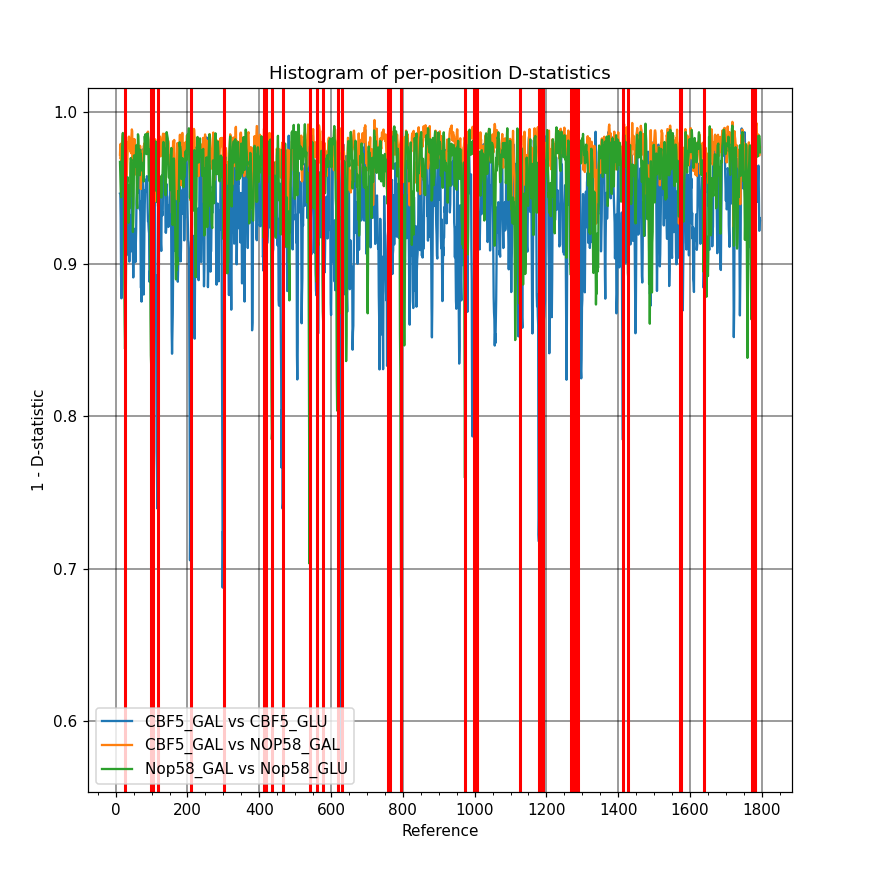

In [11]:
%matplotlib notebook
stats_files = [CBF5_GAL_vs_CBF5_GLU, CBF5_GAL_vs_NOP58_GAL, Nop58_GAL_vs_Nop58_GLU, IVT_vs_CBF5_GAL_and_Nop58_GAL]
labels = ["CBF5_GAL vs CBF5_GLU", "CBF5_GAL vs NOP58_GAL", "Nop58_GAL vs Nop58_GLU", "IVT vs CBF5_GAL_and_Nop58_GAL"]
save_fig_path = None

title = "Histogram of per-position D-statistics"
y_label = "Reference"

fig = plt.figure(figsize=(8, 8))
panel1 = plt.axes([0.1, 0.1, .8, .8])
panel1.set_xlabel("Reference")
panel1.set_ylabel("1 - D-statistic")
panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)

panel1.set_title(label=title)

for i in range(len(stats_files)):
    assert os.path.exists(stats_files[i])
    ts = tombo_stats.TomboStats(stats_files[i])
    for contig in ts:
        if contig[0] == "RDN18-1" and contig[1] == "+":
            all_data = contig[4]
            panel1.plot([x[1] for x in all_data], [x[0] for x in all_data], label=labels[i])

for mod in mods_data["RDN18-1"]:
    pos = mod[0]
    strand = mod[1]
    find = mod[2]
    mods = mod[3]
    panel1.axvline(x=pos, linewidth=2, color='r')
            
            
panel1.xaxis.set_major_locator(ticker.MultipleLocator(200))
panel1.xaxis.set_minor_locator(ticker.MultipleLocator(50))

panel1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

panel1.legend()

# option to save figure or just show it
if save_fig_path is not None:
    plt.savefig(save_fig_path)


<IPython.core.display.Javascript object>


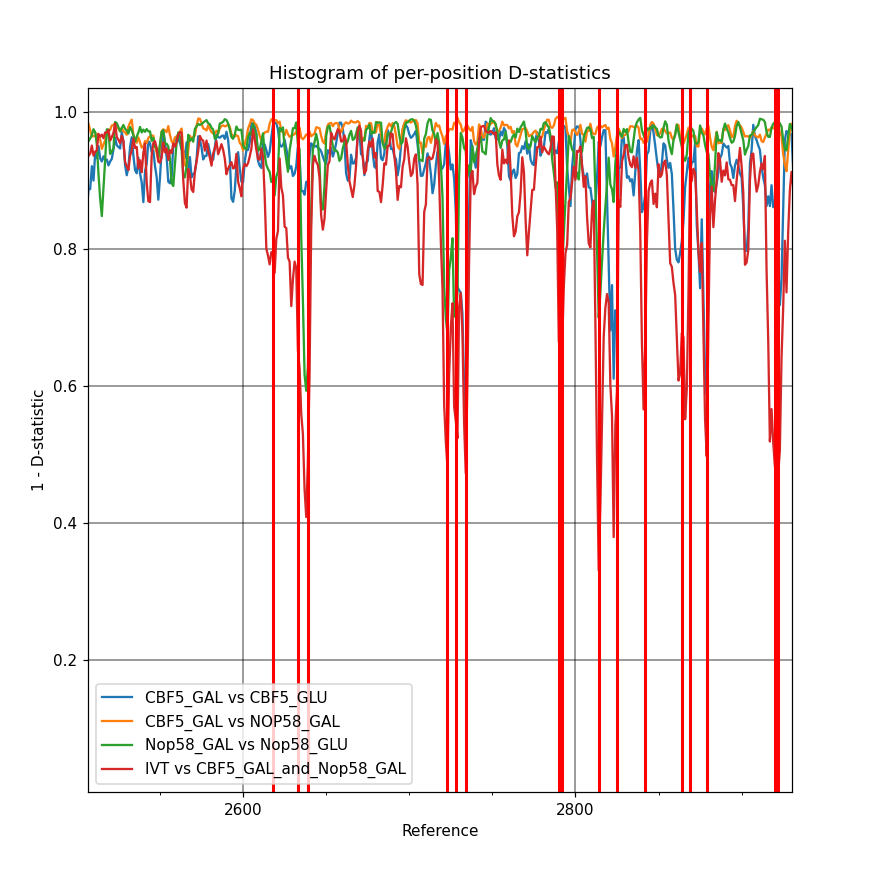

In [12]:
%matplotlib notebook
stats_files = [CBF5_GAL_vs_CBF5_GLU, CBF5_GAL_vs_NOP58_GAL, Nop58_GAL_vs_Nop58_GLU, IVT_vs_CBF5_GAL_and_Nop58_GAL]
labels = ["CBF5_GAL vs CBF5_GLU", "CBF5_GAL vs NOP58_GAL", "Nop58_GAL vs Nop58_GLU", "IVT vs CBF5_GAL_and_Nop58_GAL"]
# stats_files = [IVT_vs_CBF5_GAL_and_Nop58_GAL]
# labels = ["IVT vs CBF5_GAL_and_Nop58_GAL"]

save_fig_path = None

title = "Histogram of per-position D-statistics"
y_label = "Reference"

fig = plt.figure(figsize=(8, 8))
panel1 = plt.axes([0.1, 0.1, .8, .8])
panel1.set_xlabel("Reference")
panel1.set_ylabel("1 - D-statistic")
panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)
panel1.set_title(label=title)

for i in range(len(stats_files)):
    assert os.path.exists(stats_files[i])
    ts = tombo_stats.TomboStats(stats_files[i])
    for contig in ts:
        if contig[0] == "RDN25-1" and contig[1] == "+":
            all_data = contig[4]
            panel1.plot([x[1] for x in all_data], [x[0] for x in all_data], label=labels[i])

for mod in mods_data["RDN25-1"]:
    pos = mod[0]
    strand = mod[1]
    find = mod[2]
    mods = mod[3]
    panel1.axvline(x=pos, linewidth=2, color='r')
            

            
panel1.xaxis.set_major_locator(ticker.MultipleLocator(200))
panel1.xaxis.set_minor_locator(ticker.MultipleLocator(50))

panel1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

panel1.legend()

# option to save figure or just show it
if save_fig_path is not None:
    plt.savefig(save_fig_path)

In [8]:
# stats_files = [CBF5_GAL_vs_CBF5_GLU, CBF5_GAL_vs_NOP58_GAL, Nop58_GAL_vs_Nop58_GLU, IVT_vs_CBF5_GAL_and_Nop58_GAL]
# labels = ["CBF5_GAL vs CBF5_GLU", "CBF5_GAL vs NOP58_GAL", "Nop58_GAL vs Nop58_GLU", "IVT vs CBF5_GAL_and_Nop58_GAL"]

def get_data_from_tombo(stats_file, contig_name, strand="+"):
    assert os.path.exists(stats_file)
    ts = tombo_stats.TomboStats(stats_file)
    for contig in ts:
        if contig[0] == contig_name and contig[1] == strand:
            all_data = contig[4]
            raw_data = [1-x[0] for x in all_data][50:]
            ref_positions = [x[1] for x in all_data][50:]
            return raw_data, ref_positions

def get_score(n):
    if n == 0:
        return -2
    elif n == 1:
        return 1
    else:
        return 1
    
def is_position_modified(position, peaks, properties, min_ref, delta=5):
    for l, r in zip(properties["left_ips"]+min_ref, properties["right_ips"]+min_ref):
        if l <= position <= r:
            return True

        
def get_peaks_accuracy(peaks, properties, mods_data, contig_name, min_ref, max_ref, delta=5):
    score = 0
    fp = 0
    tp = 0
    tn = 0
    fn = 0
    mod_index = 0
    mods_per_peak = []
    mod_per_peak_widths = []
    n_mods = len(mods_data[contig_name])
    for l, r in zip(properties["left_ips"]+min_ref, properties["right_ips"]+min_ref):
        total_mods = 0
        all_mods_found = []
        keep_going = True
        while keep_going:
            pos = mods_data[contig_name][mod_index][0]
            if pos < l:
                fn += 1
                mod_index += 1
            elif r < pos:
                if total_mods == 0:
                    fp += 1
                keep_going = False
            else:
                tp += 1
                total_mods += 1
                mod_index += 1
                all_mods_found.append(pos)

            if mod_index == n_mods:
                mod_index -= 1
                keep_going = False

    #         print(l, r, pos, keep_going, tp, fp, tn, fn, score)
        score += get_score(total_mods)
        if total_mods > 1:
            delta = all_mods_found[-1] - all_mods_found[0]
        else:
            delta = 0
        mods_per_peak.append([total_mods, delta])
        mod_per_peak_widths.append([r-l])
    return tp, fp, tn, fn, score, mods_per_peak, mod_per_peak_widths

def plot_fit(reg, mods_per_peak, mod_per_peak_widths):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    xs = [x[0] for x in mods_per_peak]
    ys = [x[1] for x in mods_per_peak]
    ax.scatter(xs=xs, ys=ys, zs=mod_per_peak_widths)
    z = reg.predict(X)
    ax.plot(xs=[x[0] for x in z], ys=[x[1] for x in z], zs=merge_lists(X))
    plt.show()

def get_score_and_regression(raw_data, 
                             ref_positions,
                             mods_data, 
                             contig_name,
                             function,
                             height=None, 
                             distance=None, 
                             threshold=None, 
                             width=None, 
                             prominence=None, 
                             wlen=None, 
                             rel_height=None,
                             delta=5):
    if distance is not None and distance < 1.0:
        distance = None
    if threshold is not None and threshold < 0.0:
        threshold = None
    if wlen is not None and wlen < 2:
        wlen = None
    peaks, properties = signal.find_peaks(raw_data, 
                                          height=height, 
                                          distance=distance, 
                                          threshold=threshold, 
                                          width=width, 
                                          prominence=prominence, 
                                          wlen=wlen, 
                                          rel_height=rel_height)
    min_ref = min(ref_positions)
    max_ref = max(ref_positions)
    if len(peaks) == 0:
        return None, -np.inf, 0, 0, get_true_negatives(mods_data[contig_name], min_ref, max_ref, delta=delta), len(mods_data[contig_name]), None, None, peaks, properties
    tp, fp, tn, fn, score, mods_per_peak, mod_per_peak_widths = function(peaks, properties, mods_data, contig_name, min_ref, max_ref, delta=delta)
    X, y = np.array(mod_per_peak_widths), np.array(mods_per_peak)
    reg = LinearRegression().fit(X, y)
#     print(reg.coef_)
#     print(reg.intercept_)
    reg_score = reg.score(X, y)
#     print(tp, fp, tn, fn, score, reg_score, sum(reg.coef_)[0]) 
#     if score > 15:
#         reg_score += sum(reg.coef_)[0]
    total_score = score + 30*(reg_score) - fn
    return reg, total_score, tp, fp, tn, fn, mods_per_peak, mod_per_peak_widths, peaks, properties


In [9]:
def is_position_modified2(position, peaks, properties, min_ref, delta=5):
    for peak in peaks:
        if (peak-delta+min_ref) <= position <= (peak+delta+min_ref):
            return True

        
def collect_close_peaks(peaks, properties, delta):
    new_peaks = []
    new_properties = []
    prev = peaks[0]
    curr_peaks = [peaks[0]]
    curr_properties = {"right_ips": [properties["right_ips"][0]], "left_ips": [properties["left_ips"][0]]}
    for i, peak in enumerate(peaks[1:]):
        if peak <= (prev + delta + delta - 1):
            curr_peaks.append(peak)
            curr_properties["right_ips"].append(properties["right_ips"][i+1])
            curr_properties["left_ips"].append(properties["left_ips"][i+1])
        else:
            new_peaks.append(curr_peaks)
            new_properties.append(curr_properties)
            curr_peaks = [peak]
            curr_properties = {"right_ips": [properties["right_ips"][i+1]], "left_ips": [properties["left_ips"][i+1]]}
        prev = peak
    new_peaks.append(curr_peaks)
    new_properties.append(curr_properties)
    return new_peaks, new_properties


def get_score2(n, n_peaks):
    ratio = n/n_peaks
    if ratio == 0:
        return -1
    elif ratio == 1:
        return 1*n_peaks
    else:
        return ratio
    
def get_true_negatives(contig_data, min_ref, max_ref, delta=5):
    n_mods = len(contig_data)
    tn = max_ref - min_ref
    prev_pos = min_ref
    first = True
    for x in contig_data:
        mod_pos = x[0]
        tn -= 1
        if first:
            tn -= min([mod_pos-prev_pos, delta])
            first = False
        else:
            tn -= min([(mod_pos-prev_pos)-1, 2*delta])
        prev_pos = mod_pos
    tn -= min([(max_ref-mod_pos), delta])
    return tn    

def get_peaks_accuracy2(peaks, properties, mods_data, contig_name, min_ref, max_ref, delta=5):
    contig_data = mods_data[contig_name]
    n_mods = len(contig_data)
    score = 0
    fp = 0
    tp = 0
    og_tn = get_true_negatives(contig_data, min_ref, max_ref, delta=5)
    tn = og_tn
    fn = 0
    mod_index = 0
    mods_per_peak = []
    mod_per_peak_widths = []
    new_peaks, new_properties = collect_close_peaks(peaks, properties, delta)
    not_passed_last_mod = True
    for i, peak_set in enumerate(new_peaks):
        l = peak_set[0]-delta+min_ref
        r = peak_set[-1]+delta+min_ref
        total_mods = 0
        all_mods_found = []
        keep_going = True
        if not not_passed_last_mod:
            fp += 1
        while keep_going and not_passed_last_mod:
            pos = contig_data[mod_index][0]
            if pos < l:
                fn += 1
                mod_index += 1
            elif r < pos:
                keep_going = False
            else:
                tp += 1
                total_mods += 1
                mod_index += 1
                all_mods_found.append(pos)

            if mod_index == n_mods:
                keep_going = False
                not_passed_last_mod = False
        
#             print(l, r, pos, keep_going, tp, fp, tn, fn, score)
        if total_mods == 0:
            fp += 1
        score += get_score2(total_mods, len(peak_set))
        if total_mods > 1:
            mod_delta = all_mods_found[-1] - all_mods_found[0]
        else:
            mod_delta = 0
        mods_per_peak.append([total_mods, mod_delta])
#         mod_per_peak_widths.append([r-l])
#         print(new_properties[i])
#         print((new_properties[i]["right_ips"][-1]+min_ref), (new_properties[i]["left_ips"][0]+min_ref))
        mod_per_peak_widths.append([(new_properties[i]["right_ips"][-1]+min_ref)-(new_properties[i]["left_ips"][0]+min_ref), len(peak_set)])
    
    while mod_index < n_mods:
        pos = contig_data[mod_index][0]
        fn += 1
        mod_index += 1
    assert n_mods == tp + fn, "{} != {} + {}".format(n_mods, tp, fn)
    return tp, fp, tn-fp, fn, score, mods_per_peak, mod_per_peak_widths



### Hyperparameter Tuning
Using hyperopt to do a bayesian hyperparameter optimization
https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a


In [10]:
contig_name = "RDN25-1"
def objective(params):

    reg, total_score, tp, fp, tn, fn, mods_per_peak, mod_per_peak_widths, peaks, properties = get_score_and_regression(
        raw_data, 
        ref_positions,
        mods_data, 
        contig_name, 
        get_peaks_accuracy2,
        **params)

    return {'loss': -total_score, 'params': params, 'status': STATUS_OK}

stats_files = [IVT_vs_CBF5_GAL_and_Nop58_GAL]
labels = ["IVT vs CBF5_GAL_and_Nop58_GAL"]
raw_data, ref_positions = get_data_from_tombo(stats_files[0], contig_name)
min_ref = min(ref_positions)


In [11]:
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK

space = {
    'height': hp.uniform('height', 0, .5),
#     'distance': hp.quniform('distance', -1.0, 10, 1),
#     'threshold': hp.uniform('threshold', -1.0, 1.0),
    'width': hp.quniform('width', 0, 5, 1.0),
#     'prominence': hp.uniform('prominence', 0, 1.0),
    'wlen': hp.quniform('wlen', -1.0, 60, 1),
    'rel_height': hp.uniform('rel_height', 0, 1.0)
#     'delta': hp.quniform('delta', 1, 7, 1)
}
# Algorithm
tpe_algorithm = tpe.suggest
# Trials object to track progress
bayes_trials = Trials()
MAX_EVALS = 1000
# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials)
print(best)


100%|██████████| 1000/1000 [01:00<00:00,  8.92trial/s, best loss: -78.67274836081268]
{'height': 0.21167990051823207, 'rel_height': 0.7384145215886212, 'width': 2.0, 'wlen': 15.0}


In [84]:
threshold, width, prominence, distance, height, wlen, rel_height = None, 1, 0.1, None, 0.2, None, 0.9
params = {'distance': 2.0, 'height': 0.2959250003809115, 'prominence': 0.11429451218571234, 'rel_height': 0.8861512083132655, 'threshold': 0.00030208778547160023, 'width': 2.2135169834611252, 'wlen': 13.0}
params = {'distance': 5.0, 'height': 0.2532024424595917, 'prominence': 0.13614535026861102, 'rel_height': 0.8085693579673158, 'threshold': -0.6946835603575771, 'width': 2.0, 'wlen': 13.0}
params = {'distance': 5.0, 'height': 0.28008964044812923, 'prominence': 0.14036364732461878, 'rel_height': 0.7939621597758635, 'threshold': -0.7623402891411355, 'width': 1.0, 'wlen': 11.0}
params = {'distance': 5.0, 'height': 0.32388223307312536, 'prominence': 0.15423433458395056, 'rel_height': 0.783646978134658, 'threshold': -0.45591409313684317, 'width': 2.0, 'wlen': 18.0}
params = {'height': 0.1304285131769858, 'prominence': 0.25499598533732076, 'rel_height': 0.7611033115158883, 'width': 5.0, 'wlen': 38.0}
params = {'height': 0.1304285131769858, 'prominence': 0.25499598533732076, 'rel_height': 0.7611033115158883, 'width': 5.0, 'wlen': 38.0}
params = {'height': 0.29688578451045017, 'rel_height': 0.8133726485542713, 'width': 5.0}
params = {'height': 0.22545609963114388, 'rel_height': 0.6919027485788268, 'width': 2.0, 'wlen': 58.0}
params = {'height': 0.2493486921901364, 'rel_height': 1, 'width': 2.0, 'wlen': 29.0}




    
# print(FUNCTION)
reg, total_score, tp, fp, tn, fn, mods_per_peak, mod_per_peak_widths, peaks, properties = get_score_and_regression(raw_data, 
                                                                                                                   ref_positions,
                                                                                                                   mods_data, 
                                                                                                                   contig_name,
                                                                                                                   get_peaks_accuracy2,
                                                                                                                   **params)

print(total_score, tp, fp, tn, fn)
# # print(mods_per_peak, mod_per_peak_widths)
X, y = np.array(mod_per_peak_widths), np.array(mods_per_peak)
# mod_per_peak_widths [delta, num_peaks]
# mods_per_peak [peaks, pos_delta]
# print(X, y)
print(reg.score(X, y))
print(reg.coef_)


-5.057368769167702 34 0 2788 41
0.27586548547218787
[[0.00257333 0.55501304]
 [0.03312028 2.51682708]]


[[0.00257333 0.55501304]]
0.09682806673573884


<IPython.core.display.Javascript object>


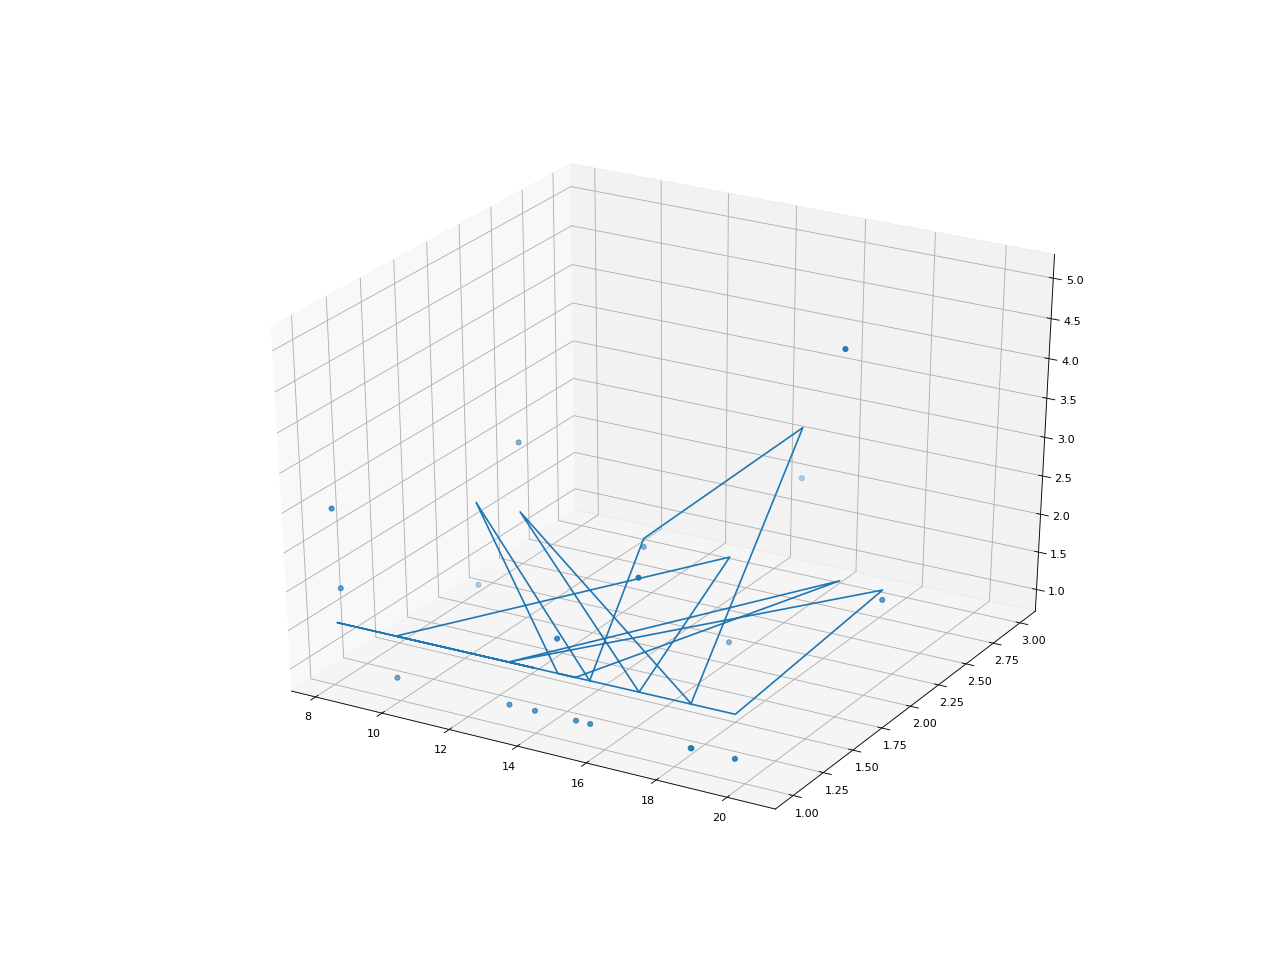

[[0.03312028 2.51682708]]
0.3028216811021699


<IPython.core.display.Javascript object>


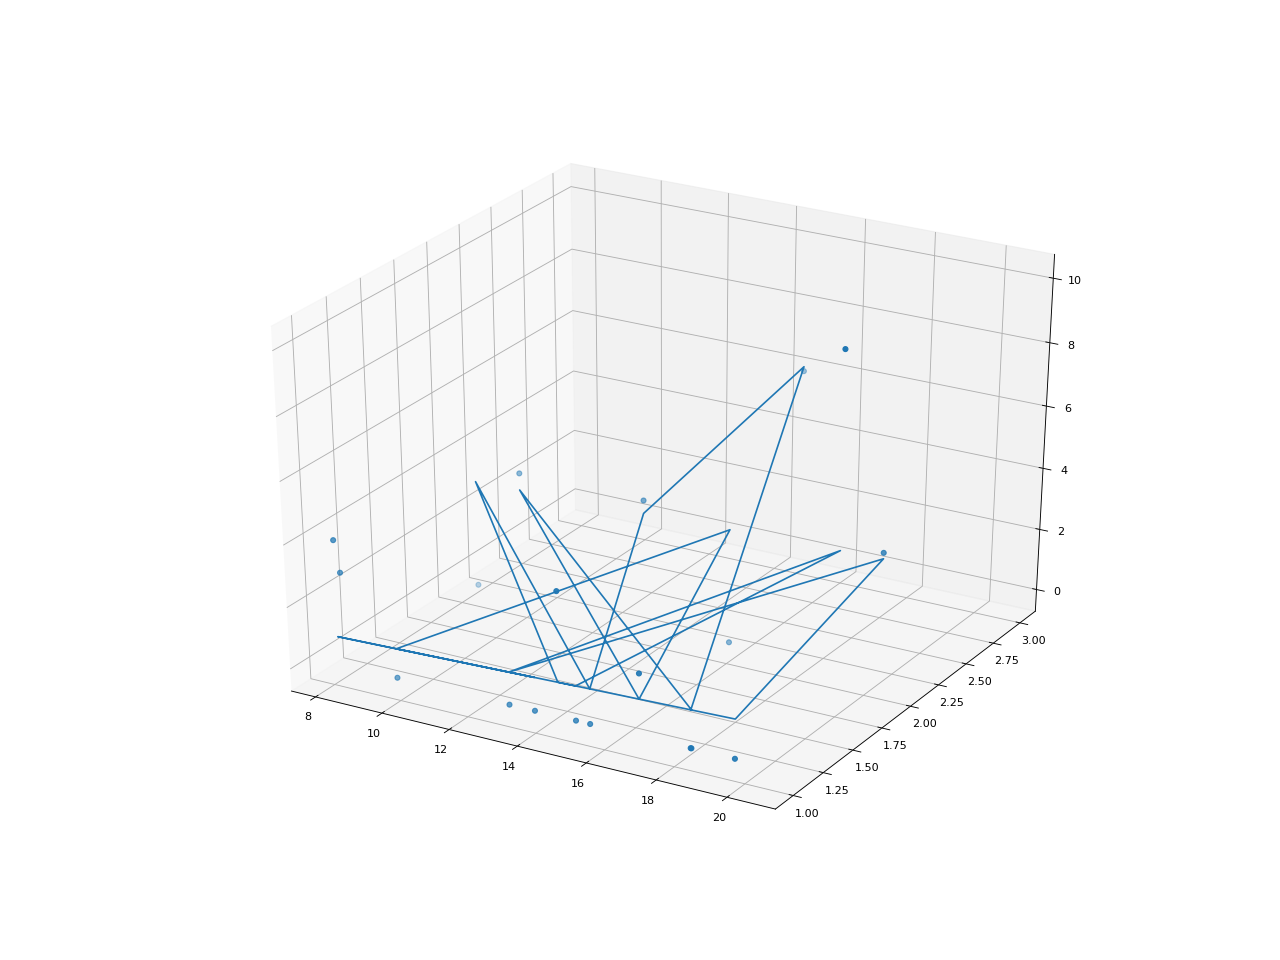

In [85]:
%matplotlib notebook
# Mod width
X, y = np.array(mod_per_peak_widths), np.array([[x[0]] for x in mods_per_peak])
reg = LinearRegression().fit(X, y)
reg_score = reg.score(X, y)
print(reg.coef_)
print(reg_score)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = [x[0] for x in mod_per_peak_widths]
ys = [x[1] for x in mod_per_peak_widths]
ax.scatter(xs=xs, ys=ys, zs=[x[0] for x in mods_per_peak])
z = reg.predict(X)
ax.plot(xs=xs, ys=ys, zs=[x[0] for x in z])
plt.show()

# # Plot num_peaks
X, y = np.array(mod_per_peak_widths), np.array([[x[1]] for x in mods_per_peak])
reg = LinearRegression().fit(X, y)
reg_score = reg.score(X, y)
print(reg.coef_)
print(reg_score)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = [x[0] for x in mod_per_peak_widths]
ys = [x[1] for x in mod_per_peak_widths]
ax.scatter(xs=xs, ys=ys, zs=[x[1] for x in mods_per_peak])
z = reg.predict(X)
ax.plot(xs=xs, ys=ys, zs=[x[0] for x in z])
plt.show()


In [1]:
%matplotlib notebook
title = "Histogram of per-position D-statistics"
contig_name = "RDN25-1"
fig = plt.figure(figsize=(8, 8))
panel1 = plt.axes([0.1, 0.1, .8, .8])
panel1.set_xlabel("Reference")
panel1.set_ylabel("D-statistic")
panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)
panel1.set_title(label=title)
panel1.plot(ref_positions, raw_data, label=labels[0])
delta = 5 
FUNCTION=get_peaks_accuracy2
if FUNCTION==get_peaks_accuracy:
    ipm = is_position_modified
else:
    ipm = is_position_modified2
    
# new_peaks, new_properties = collect_close_peaks(peaks, properties, delta)
# for i, peak_set in enumerate(new_peaks):
#     print([x+min_ref for x in peak_set])
#     print(new_properties[i]["left_ips"]+min_ref, new_properties[i]["right_ips"]+min_ref)

tp = 0
fn = 0
for mod in mods_data[contig_name]:
    pos = mod[0]
    strand = mod[1]
    find = mod[2]
    mods = mod[3]
    if ipm(pos, peaks, properties, min_ref, delta=delta):
        panel1.axvline(x=pos, linewidth=2, color='b')
        tp += 1
    else:
        panel1.axvline(x=pos, linewidth=2, color='r')
        fn += 1
print(peaks)
panel1.plot([ref_positions[x] for x in peaks], [raw_data[x] for x in peaks], "x")
panel1.vlines(x=[ref_positions[x] for x in peaks], ymin=[raw_data[x] for x in peaks] - properties["prominences"],
            ymax = [raw_data[x] for x in peaks], color = "C1")
panel1.hlines(y=properties["width_heights"], xmin=properties["left_ips"]+min_ref,
               xmax=properties["right_ips"]+min_ref, color = "C1")
panel1.xaxis.set_major_locator(ticker.MultipleLocator(200))
panel1.xaxis.set_minor_locator(ticker.MultipleLocator(50))

panel1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

panel1.legend()
plt.show()
# print(tp, fn)

NameError: name 'plt' is not defined

0 0 2952.0 75 0.0 0.0
34 1 2787 41 0.0003586800573888092 0.4533333333333333
36 2 2786 39 0.0007173601147776184 0.48
38 6 2782 37 0.002152080344332855 0.5066666666666667
39 15 2773 36 0.005380200860832138 0.52
40 16 2772 35 0.005738880918220947 0.5333333333333333
42 18 2770 33 0.006456241032998565 0.56
43 19 2769 32 0.0068149210903873745 0.5733333333333334
45 25 2763 30 0.008967001434720229 0.6
46 48 2740 29 0.01721664275466284 0.6133333333333333
49 60 2728 26 0.021520803443328552 0.6533333333333333
50 73 2715 25 0.02618364418938307 0.6666666666666666
51 85 2703 24 0.03048780487804878 0.68
52 97 2691 23 0.03479196556671449 0.6933333333333334
53 111 2677 22 0.039813486370157816 0.7066666666666667
54 150 2638 21 0.05380200860832138 0.72
55 163 2625 20 0.058464849354375896 0.7333333333333333
56 181 2607 19 0.06492109038737447 0.7466666666666667
57 189 2599 18 0.06779053084648494 0.76
58 192 2596 17 0.06886657101865136 0.7733333333333333
59 197 2591 16 0.07065997130559541 0.7866666666666666

<IPython.core.display.Javascript object>


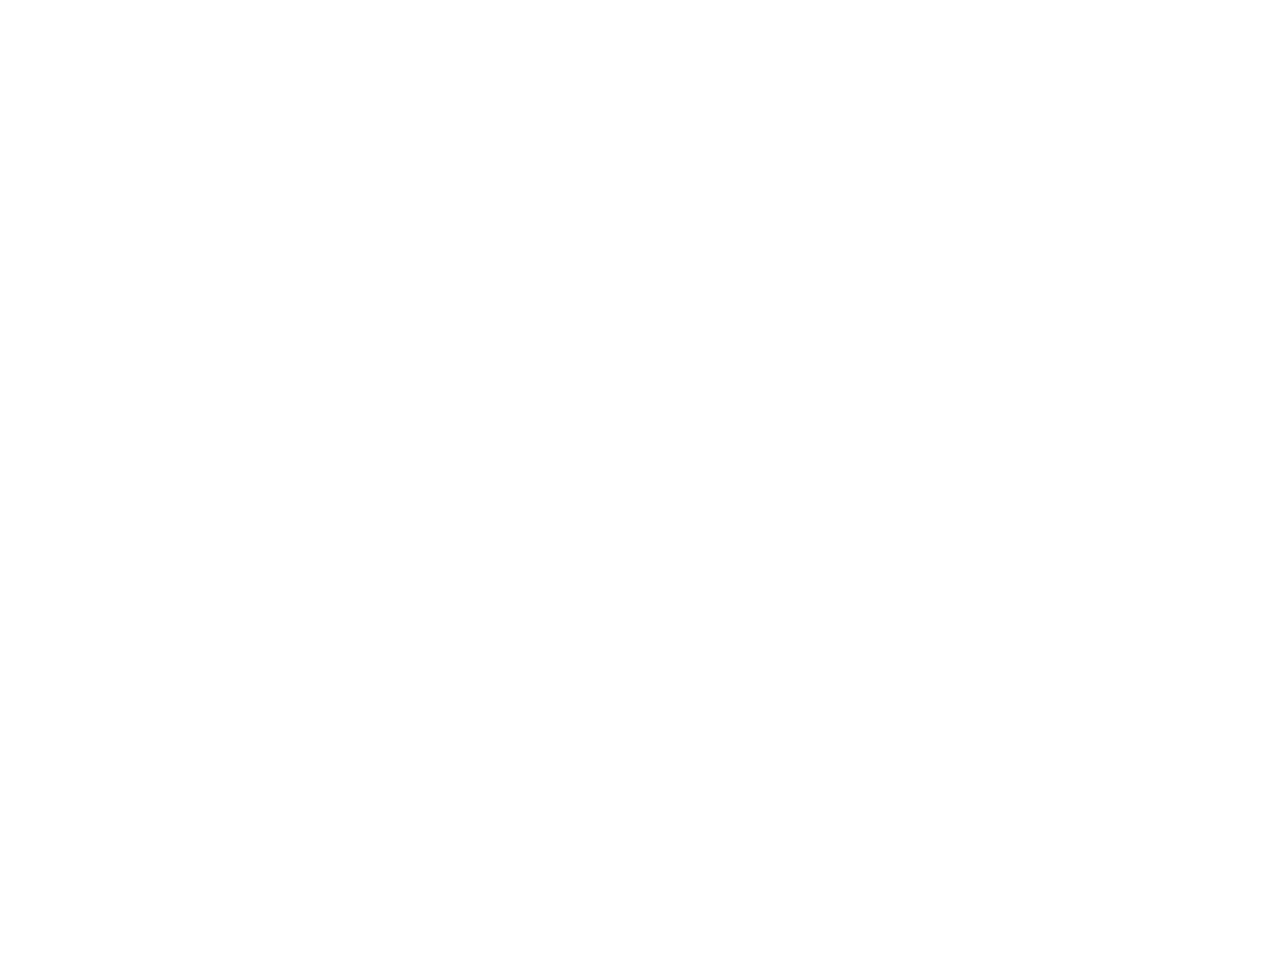

ValueError: Reordering is not turned on, and the x array is not increasing: [0.00000000e+00 3.58680057e-04 7.17360115e-04 2.15208034e-03
 5.38020086e-03 5.73888092e-03 6.45624103e-03 6.81492109e-03
 8.96700143e-03 1.72166428e-02 2.15208034e-02 2.61836442e-02
 3.04878049e-02 3.47919656e-02 3.98134864e-02 5.38020086e-02
 5.84648494e-02 6.49210904e-02 6.77905308e-02 6.88665710e-02
 7.06599713e-02 7.31707317e-02 7.74748924e-02 8.10616930e-02
 8.03443329e-02 8.14203730e-02 8.17790531e-02 8.21377331e-02
 7.99856528e-02 8.28550933e-02 7.20946915e-02 7.10186514e-02
 6.81492109e-02 1.00000000e+00]

In [213]:
%matplotlib notebook

fpr = []
tpr = []
params = {'delta': 3.0, 'height': 0, 'rel_height': 1, 'width': 1.0}

for x in np.linspace(1, 0.001, 1000):
    params["height"] = x
    reg, total_score, tp, fp, tn, fn, mods_per_peak, mod_per_peak_widths, peaks, properties = get_score_and_regression(raw_data, 
                                                                                                                   ref_positions,
                                                                                                                   mods_data, 
                                                                                                                   contig_name,
                                                                                                                   get_peaks_accuracy2,
                                                                                                                   **params)
    false_positive_rate = fp / (fp + tn)
    true_positive_rate_recall = tp / (tp + fn)
    if false_positive_rate in fpr or true_positive_rate_recall in tpr:
        continue
        
    fpr.append(false_positive_rate)
    tpr.append(true_positive_rate_recall)
    print(tp, fp, tn, fn, false_positive_rate, true_positive_rate_recall)

fpr.append(1)
tpr.append(1)

# print(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(title)
plt.legend(loc="lower right")
plt.show()



### Get peaks from pseudoU knockdown


In [178]:
def get_possible_mod_pos(reference, peaks, base, delta=2):
    """Get possible modification positions"""
    mods = []
    for peak in peaks:
        if reference[peak] == base:
            mods.append([peak, [peak]])
        else:
            i = 1
            stop = False
            found = []
            while i <= delta and not stop:
                if reference[peak-i] == base:
                    found.append(peak-i)
                    stop = True
                if reference[peak+i] == base:
                    found.append(peak+i)
                    stop = True
                i += 1
            mods.append([peak, found])

    return mods


### Hyperparameter Tuning
Using hyperopt to do a bayesian hyperparameter optimization
https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a


In [205]:
stats_files = [CBF5_GAL_vs_CBF5_GLU, CBF5_GAL_vs_NOP58_GAL, Nop58_GAL_vs_Nop58_GLU, IVT_vs_CBF5_GAL_and_Nop58_GAL]
labels = ["CBF5_GAL vs CBF5_GLU", "CBF5_GAL vs NOP58_GAL", "Nop58_GAL vs Nop58_GLU", "IVT vs CBF5_GAL_and_Nop58_GAL"]
contig_name = "RDN25-1"



def get_peaks_accuracy3(peaks, called_mods, mods_data, contig_name, min_ref):
    tp = 0
    fn = 0
    fp = 0

    all_possible_mod_positions = []
    for mod in called_mods:
        ref_index = mod[0]
        possible_mod_pos = mod[1]
        for x in possible_mod_pos:
            all_possible_mod_positions.append(x+min_ref)
            fp += 1
            assert rh.get_sequence(contig_name, x+min_ref, x+min_ref+1) == base, "{}: {} != {}".format(x+min_ref, rh.get_sequence(contig_name, x+min_ref, x+min_ref+1), base)

    all_possible_mod_positions = set(all_possible_mod_positions)
    for mod in mods_data[contig_name]:
        pos = mod[0]
        strand = mod[1]
        find = mod[2]
        all_mods = mod[3]
        if all_mods == "Tl":
            if pos in all_possible_mod_positions:
                tp += 1
                fp -= 1
            else:
                fn += 1
            assert rh.get_sequence(contig_name, pos, pos+1) == base, "{}: {} != {}".format(pos, rh.get_sequence(contig_name, x+min_ref, x+min_ref+1), base)
    
    return tp, fn, fp





In [214]:
rh = ReferenceHandler("/Users/andrewbailey/CLionProjects/personal/projects/ares_rRNA/reference/yeast_25S_18S.fa")
min_ref = ref_positions[0]
ref_seq = rh.get_sequence(contig_name, min_ref_pos, ref_positions[-1]+1)
base = "T"
raw_data, ref_positions = get_data_from_tombo(stats_files[0], contig_name)

def objective2(params):
    tmp_params = params
#     if tmp_params["distance"] is not None and tmp_params["distance"] < 1.0:
#         tmp_params["distance"] = None
#     if tmp_params["threshold"] is not None and tmp_params["threshold"] < 0.0:
#         tmp_params["threshold"] = None
#     if tmp_params["wlen"] is not None and tmp_params["wlen"] < 2:
#         tmp_params["wlen"] = None
    peaks, properties = signal.find_peaks(raw_data, **tmp_params)
    called_mods = get_possible_mod_pos(ref_seq, peaks, base, delta=2)
    tp, fn, fp  = get_peaks_accuracy3(peaks, called_mods, mods_data, contig_name, min_ref)
    tn = len(raw_data) - fp
    total_score = tp - (2*fn) - fp
    return {'loss': -total_score, 'params': params, 'status': STATUS_OK}

raw_data, ref_positions = get_data_from_tombo(stats_files[0], contig_name)
min_ref = min(ref_positions)


In [223]:
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK

space = {
    'height': hp.uniform('height', 0, .5),
#     'distance': hp.quniform('distance', -1.0, 10, 1),
#     'threshold': hp.uniform('threshold', -1.0, 1.0),
#     'prominence': hp.uniform('prominence', 0, 1.0),
#     'wlen': hp.quniform('wlen', -1.0, 60, 1),
#     'rel_height': hp.uniform('rel_height', 0, 1.0)
#     'delta': hp.quniform('delta', 1, 7, 1)
}
# Algorithm
tpe_algorithm = tpe.suggest
# Trials object to track progress
bayes_trials = Trials()
MAX_EVALS = 1000
# Optimize
best = fmin(fn = objective2, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials)
print(best)


100%|██████████| 1000/1000 [00:08<00:00, 122.80trial/s, best loss: 10.0]
{'height': 0.257266852936339}


{'height': 0.257266852936339}


<IPython.core.display.Javascript object>


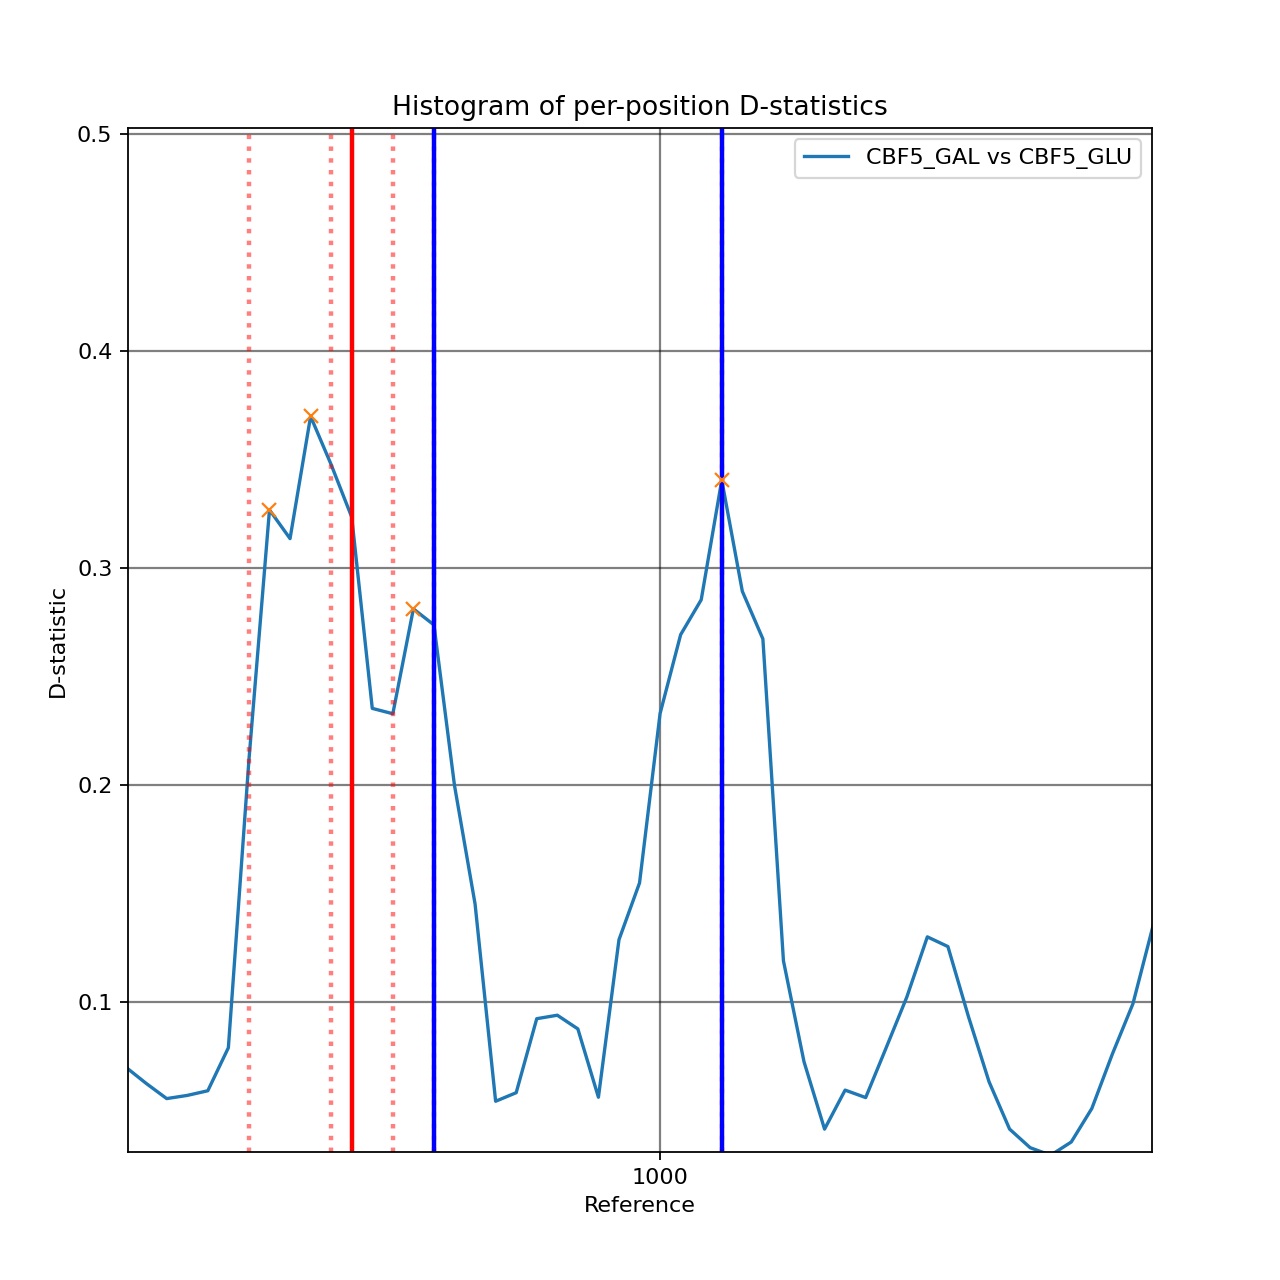

[ 721  906  909  911  929  931  936  951  985  989  998 1000 1002 2076
 2082 2136 2205 2207 2212 2259 2286 2297 2682 2769 2771 2773 2827 2871
 2889 2893 2920 2922]
True Positives: 22, False Negatives: 8, False Positives: 16


In [224]:
%matplotlib notebook

print(best)
peaks, properties = signal.find_peaks(raw_data, **best)
mods = get_possible_mod_pos(ref_seq, peaks, base, delta=2)

title = "Histogram of per-position D-statistics"
contig_name = "RDN25-1"
fig = plt.figure(figsize=(8, 8))
panel1 = plt.axes([0.1, 0.1, .8, .8])
panel1.set_xlabel("Reference")
panel1.set_ylabel("D-statistic")
panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)
panel1.set_title(label=title)
panel1.plot(ref_positions, raw_data, label=labels[0])
delta = 5 

tp = 0
fn = 0
fp = 0
all_possible_mod_positions = []

for mod in mods:
    ref_index = mod[0]
    possible_mod_pos = mod[1]
    for x in possible_mod_pos:
        all_possible_mod_positions.append(x+min_ref_pos)
        panel1.axvline(x=x+min_ref_pos, linewidth=2, color='r', linestyle=":", alpha=0.5)
        fp += 1
        assert rh.get_sequence(contig_name, x+min_ref_pos, x+min_ref_pos+1) == base

all_possible_mod_positions = set(all_possible_mod_positions)
for mod in mods_data[contig_name]:
    pos = mod[0]
    strand = mod[1]
    find = mod[2]
    all_mods = mod[3]
    if all_mods == "Tl":
#         if ipm(pos, peaks, properties, min_ref, delta=delta):
        if pos in all_possible_mod_positions:
            panel1.axvline(x=pos, linewidth=2, color='b')
            tp += 1
            fp -= 1
        else:
            panel1.axvline(x=pos, linewidth=2, color='r')
            fn += 1
        assert rh.get_sequence(contig_name, pos, pos+1) == base


print(peaks)
panel1.plot([ref_positions[x] for x in peaks], [raw_data[x] for x in peaks], "x")
if "prominences" in properties:
    panel1.vlines(x=[ref_positions[x] for x in peaks], ymin=[raw_data[x] for x in peaks] - properties["prominences"],
                ymax = [raw_data[x] for x in peaks], color = "C1")
    panel1.hlines(y=properties["width_heights"], xmin=properties["left_ips"]+min_ref,
                   xmax=properties["right_ips"]+min_ref, color = "C1")
panel1.xaxis.set_major_locator(ticker.MultipleLocator(200))
panel1.xaxis.set_minor_locator(ticker.MultipleLocator(50))

panel1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

panel1.legend()
plt.show()
print("True Positives: {}, False Negatives: {}, False Positives: {}".format(tp, fn, fp))

0 0 3340 30 0.0 0.0
9 1 3339 21 0.0002994011976047904 0.3
10 2 3338 20 0.0005988023952095808 0.3333333333333333
13 3 3337 17 0.0008982035928143712 0.43333333333333335
14 4 3336 16 0.0011976047904191617 0.4666666666666667
15 5 3335 15 0.0014970059880239522 0.5
17 7 3333 13 0.002095808383233533 0.5666666666666667
18 8 3332 12 0.0023952095808383233 0.6
19 9 3331 11 0.002694610778443114 0.6333333333333333
20 10 3330 10 0.0029940119760479044 0.6666666666666666
21 14 3326 9 0.004191616766467066 0.7
22 16 3324 8 0.004790419161676647 0.7333333333333333
23 39 3301 7 0.011676646706586826 0.7666666666666667
24 327 3013 6 0.09790419161676647 0.8


<IPython.core.display.Javascript object>


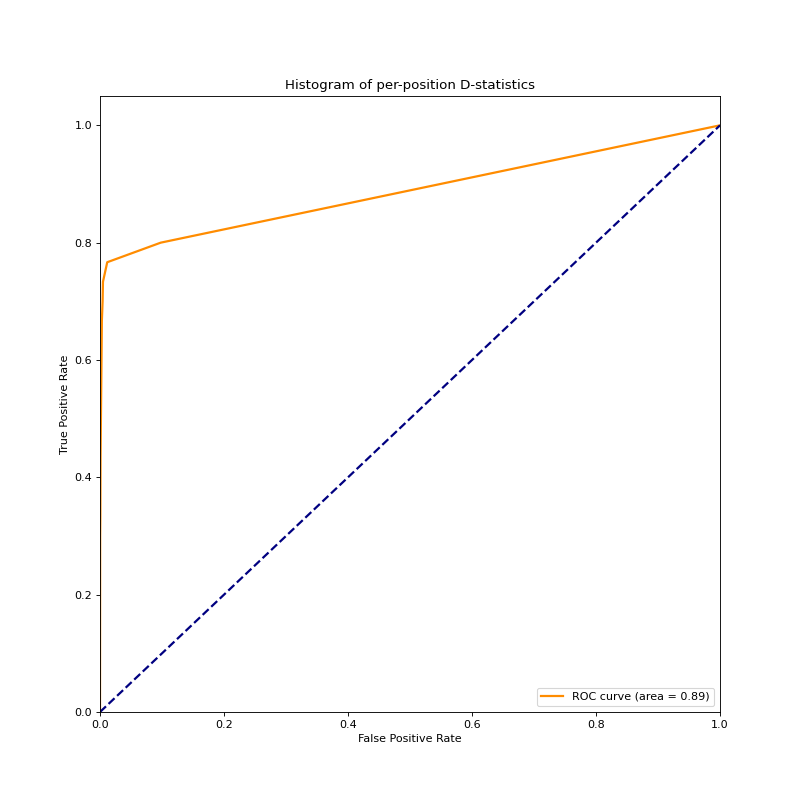

In [221]:
%matplotlib notebook

fpr = []
tpr = []
tmp_params = best
for x in np.linspace(1, 0.001, 1000):
    params["height"] = x
    peaks, properties = signal.find_peaks(raw_data, **tmp_params)

    called_mods = get_possible_mod_pos(ref_seq, peaks, base, delta=2)
    tp, fn, fp  = get_peaks_accuracy3(peaks, called_mods, mods_data, contig_name, min_ref)
    tn = len(raw_data) - fp

    false_positive_rate = fp / (fp + tn)
    true_positive_rate_recall = tp / (tp + fn)
    if false_positive_rate in fpr or true_positive_rate_recall in tpr:
        continue
        
    fpr.append(false_positive_rate)
    tpr.append(true_positive_rate_recall)
    print(tp, fp, tn, fn, false_positive_rate, true_positive_rate_recall)

fpr.append(1)
tpr.append(1)

# print(fpr, tpr)
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(title)
plt.legend(loc="lower right")
plt.show()



[2.52065427e+01 2.88695159e+01 8.17560522e+00 1.17064093e+00
 3.02100886e-01 9.44065268e-02 5.66439161e-02 7.55252214e-02
 1.88813054e-02 3.77626107e-02] [0.00720407 0.02282721 0.03845035 0.05407349 0.06969663 0.08531977
 0.10094291 0.11656604 0.13218918 0.14781232 0.16343546]


<IPython.core.display.Javascript object>


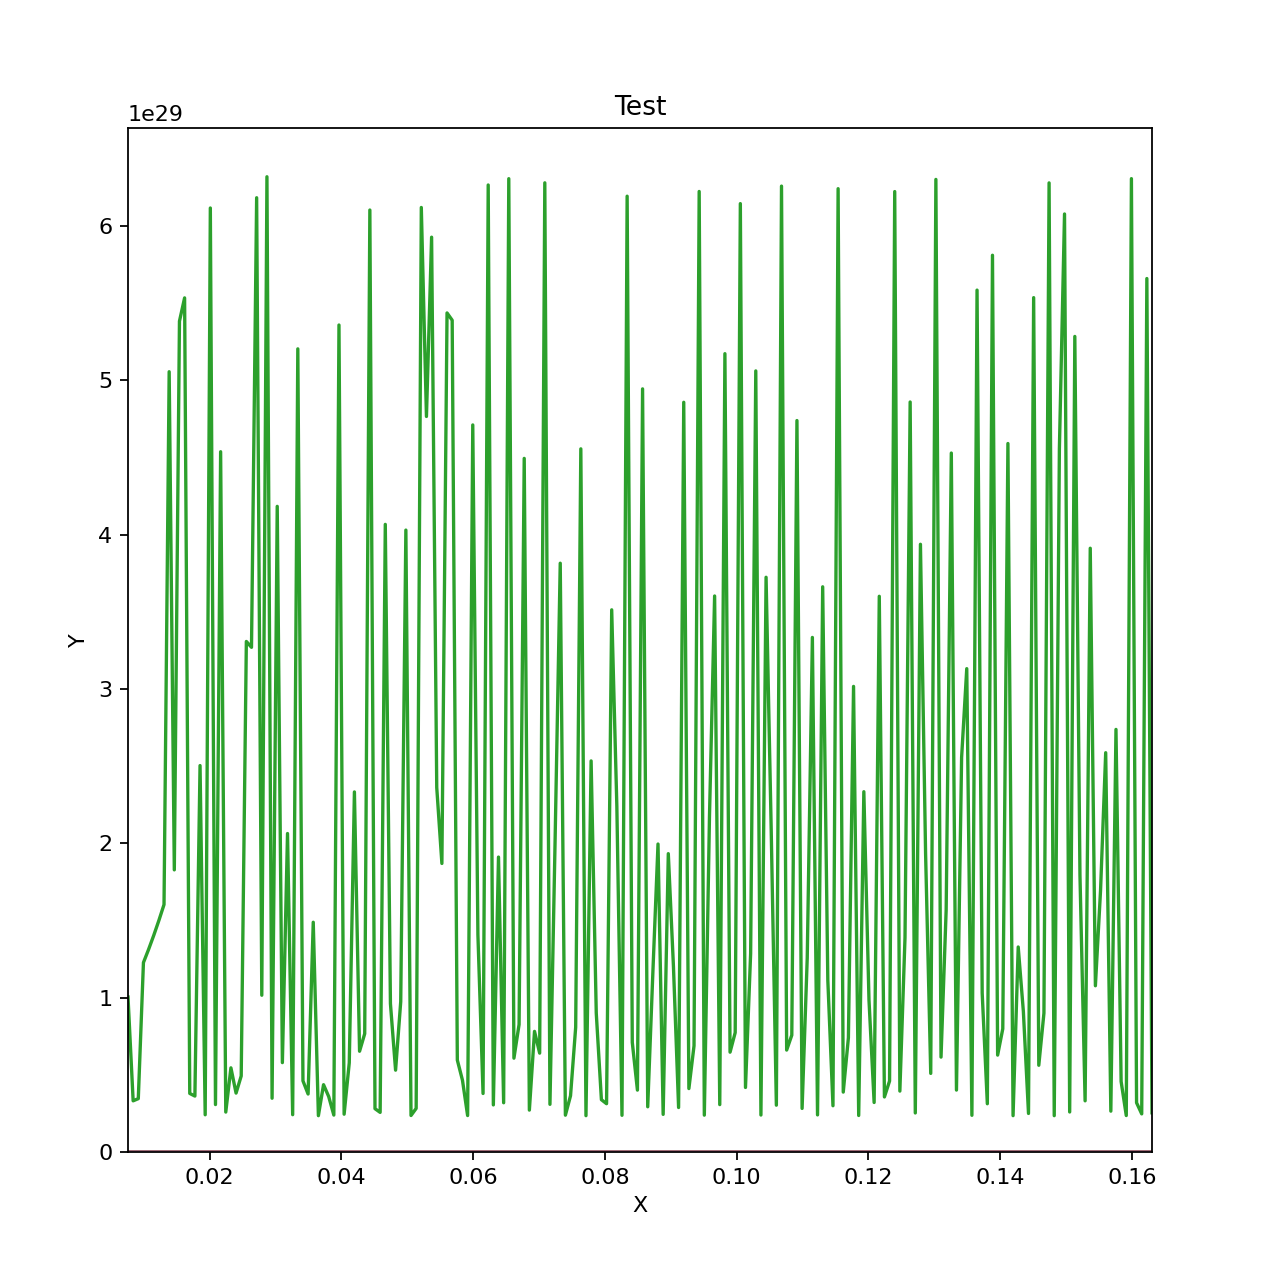

Axes(0.1,0.1;0.8x0.8)


<IPython.core.display.Javascript object>


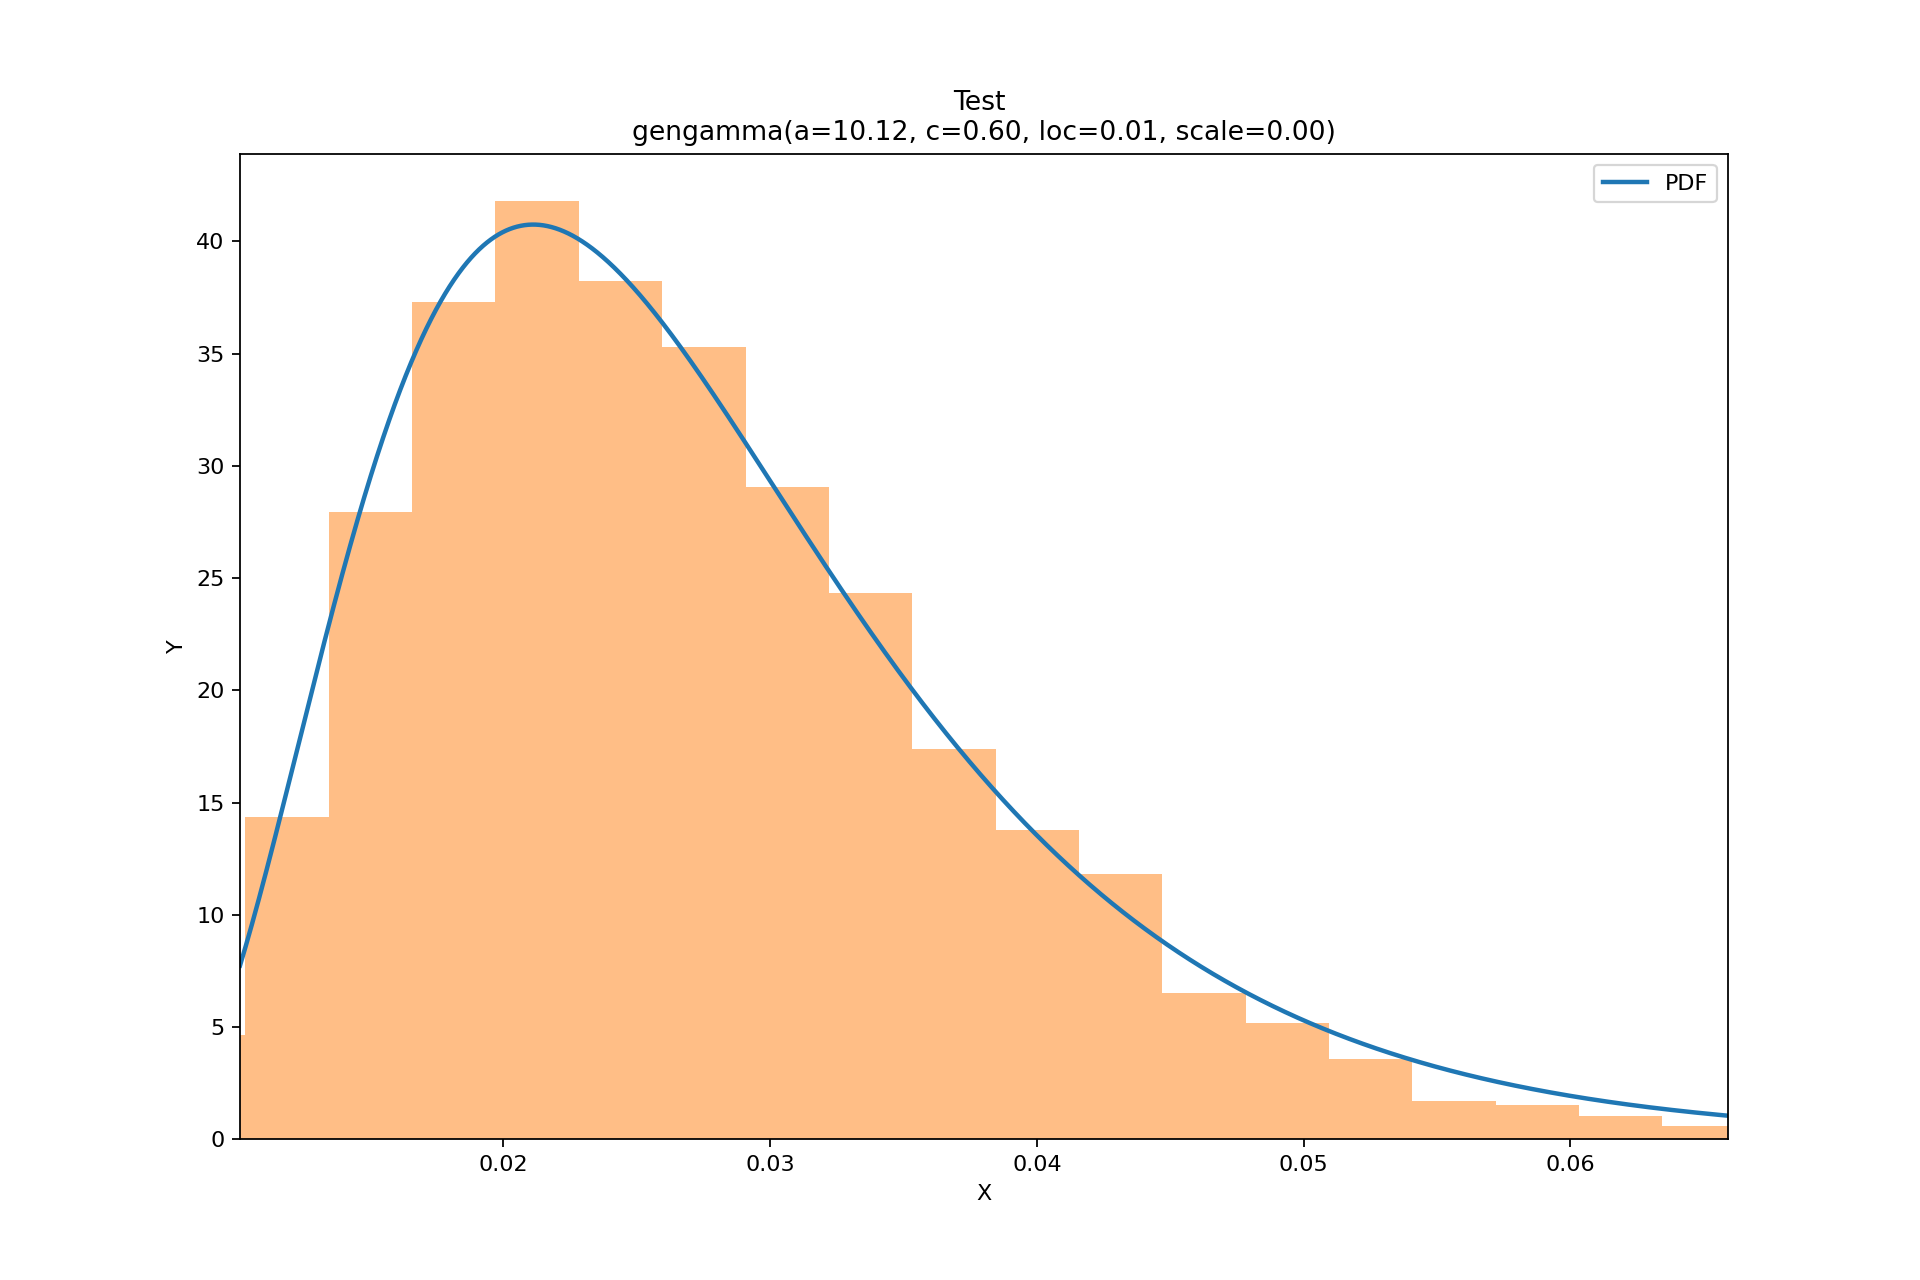

Text(0, 0.5, 'Y')

In [65]:
%matplotlib notebook

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt

# matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]
#     DISTRIBUTIONS = [st.levy_stable]
    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        print(distribution)
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass
    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

ts = tombo_stats.TomboStats(CBF5_GAL_vs_NOP58_GAL)
for contig in ts:
    if contig[0] == "RDN25-1" and contig[1] == "+":
        all_data = contig[4]
        min_pos = all_data[0][1]
        max_pos = all_data[-1][1]
        data = [1-x[0] for x in all_data]

y, x = np.histogram(data, bins=10, density=True)
print(y, x)

# Plot for comparison
fig = plt.figure(figsize=(8, 8))
panel1 = plt.axes([0.1, 0.1, .8, .8])
# ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
# dataYLim = ax.get_ylim()
panel1.hist(data, label="IVT vs Native", bins=50, density=True, alpha=0.5)

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, panel1)
best_dist = getattr(st, best_fit_name)

# Update plots
# ax.set_ylim()
print(panel1)
panel1.set_title(label="Test")
panel1.set_xlabel("X")
panel1.set_ylabel('Y')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
panel1 = pdf.plot(lw=2, label='PDF', legend=True)
# ax.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)
panel1.hist(data, label="IVT vs Native", bins=50, density=True, alpha=0.5)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

panel1.set_title("Test \n" + dist_str)
panel1.set_xlabel("X")
panel1.set_ylabel('Y')


<IPython.core.display.Javascript object>


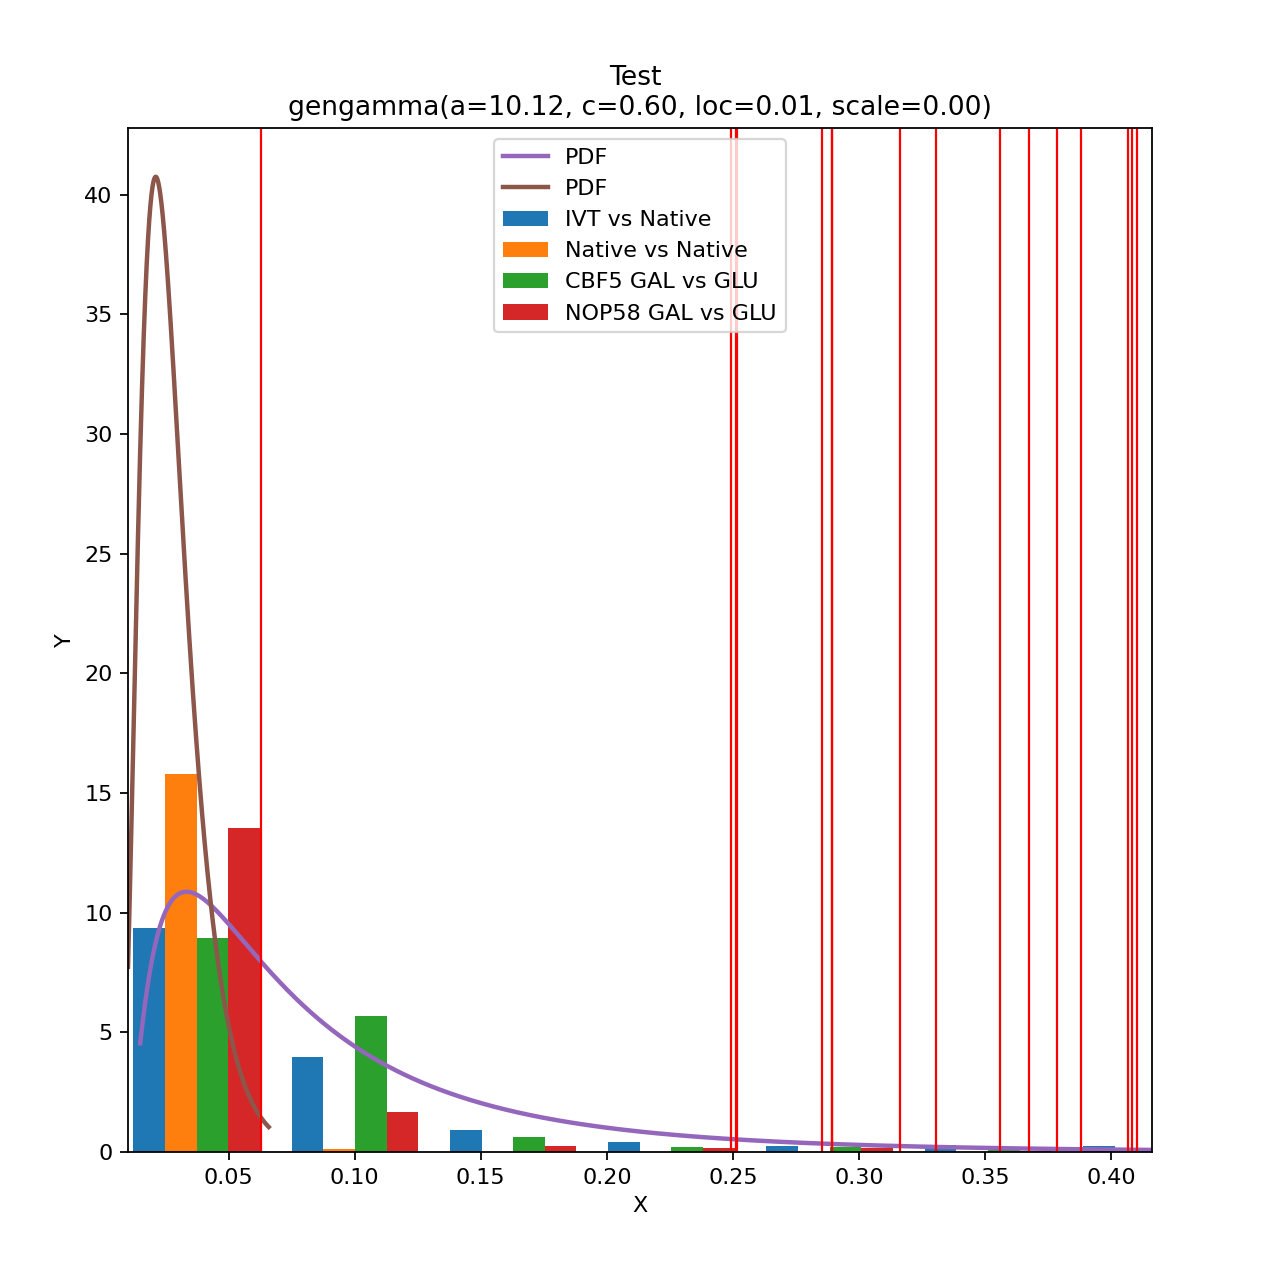

0.09828286281297204
0.027793728417526548
0.0778142927504488
0.0486842431171806
2394 0.9799274938269981
2869 0.9164800944920103


In [38]:
%matplotlib notebook
tombo_data = {}
label_data = {}
probs = []


ts = tombo_stats.TomboStats(CBF5_GAL_vs_NOP58_GAL)
for contig in ts:
    if contig[0] == "RDN25-1" and contig[1] == "+":
        all_data = contig[4]
        min_pos = all_data[0][1]
        max_pos = all_data[-1][1]
        baseline_probs = [1-x[0] for x in all_data]


ts = tombo_stats.TomboStats(CBF5_GAL_vs_CBF5_GLU)
for contig in ts:
    if contig[0] == "RDN25-1" and contig[1] == "+":
        all_data = contig[4]
        min_pos = all_data[0][1]
        max_pos = all_data[-1][1]
        pseudo_probs = [1-x[0] for x in all_data]

ts = tombo_stats.TomboStats(Nop58_GAL_vs_Nop58_GLU)
for contig in ts:
    if contig[0] == "RDN25-1" and contig[1] == "+":
        all_data = contig[4]
        min_pos = all_data[0][1]
        max_pos = all_data[-1][1]
        methyl_probs = [1-x[0] for x in all_data]


column_names = ["unmod", "mod"]
ts = tombo_stats.TomboStats(IVT_vs_CBF5_GAL_and_Nop58_GAL)
for contig in ts:
    if contig[0] == "RDN25-1" and contig[1] == "+":
        all_data = contig[4]
        min_pos = all_data[0][1]
        max_pos = all_data[-1][1]
        for x in all_data:
            tombo_data[x[1]] = [x[0], 1-x[0]]
            label_data[x[1]] = [1, 0]
            probs.append(1-x[0])

save_fig_path = None

title = "Distribution of 1-D-statistics"

fig = plt.figure(figsize=(8, 8))
panel1 = plt.axes([0.1, 0.1, .8, .8])
panel1.set_xlabel("1-D-statistic")
panel1.set_ylabel("Counts")
panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)
panel1.set_title(label=title)
panel1.hist([probs, baseline_probs, pseudo_probs, methyl_probs], label=["IVT vs Native", 
                                                                        "Native vs Native", 
                                                                        "CBF5 GAL vs GLU",
                                                                       "NOP58 GAL vs GLU"], bins=15, density=True)
params = st.gengamma.fit(probs)
pdf = make_pdf(st.gengamma, params)
panel1 = pdf.plot(lw=2, label='PDF', legend=True)
params = st.gengamma.fit(baseline_probs)
pdf = make_pdf(st.gengamma, params)
panel1 = pdf.plot(lw=2, label='PDF', legend=True)

# ax.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

panel1.set_title("Test \n" + dist_str)
panel1.set_xlabel("X")
panel1.set_ylabel('Y')
panel1.legend()

# panel1.axvline(x=np.mean(probs)-(2*(np.std(probs))), linewidth=5, color='g')
# panel1.axvline(x=np.mean(baseline_probs)-(2*(np.std(baseline_probs))), linewidth=5, color='y')
print(np.mean(probs))
print(np.mean(baseline_probs))
print(np.mean(pseudo_probs))
print(np.mean(methyl_probs))

#     kde1 = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(x)

            
for mod in mods_data["RDN25-1"]:
    pos = mod[0] 
    strand = mod[1]
    find = mod[2]
    mods = mod[3]
    label_data[pos] = [0, 1]
    if tombo_data[pos][0] > 0.85:
        print(pos, tombo_data[pos][0])
    panel1.axvline(x=tombo_data[pos][0], linewidth=1, color='r')





(10.117178194095782, 0.6043361868707837, 0.005089266394963557, 0.0004679362769767659)


<IPython.core.display.Javascript object>


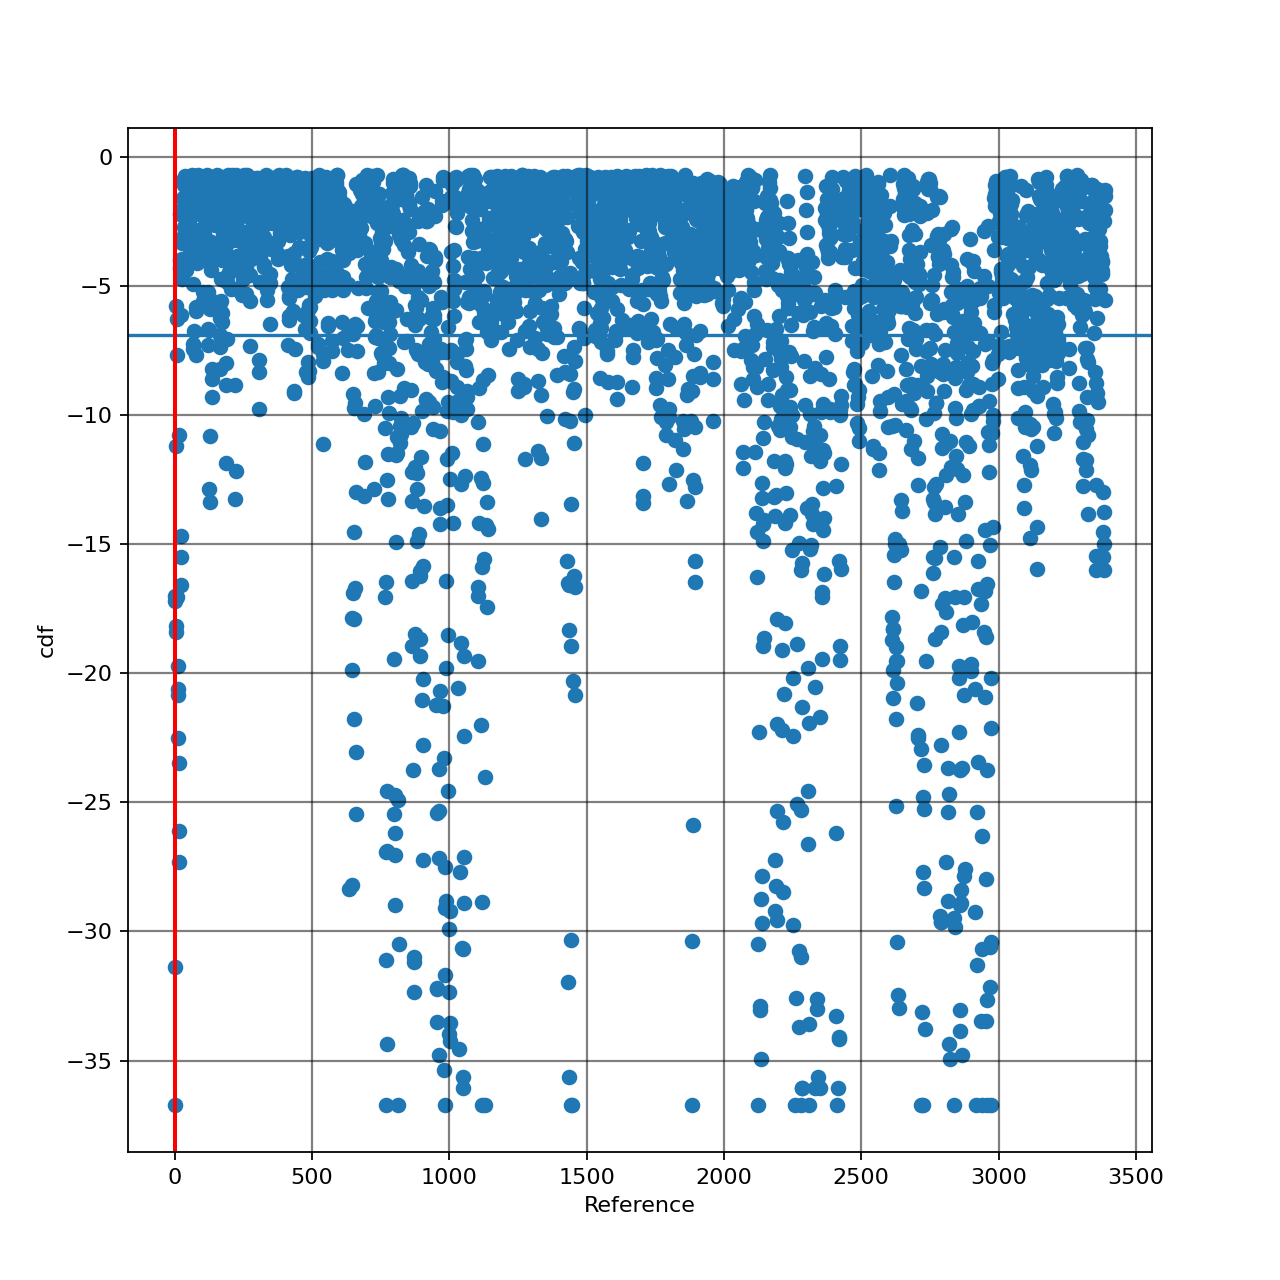

In [58]:
# Display
print(params)
arg = params[:-2]
loc = params[-2]
scale = params[-1]

# pdf = st.johnsonsu.pdf(probs, 6.22, 2.27, loc=1, scale=0)
pdf = st.gengamma.logpdf(probs, *arg, loc=loc, scale=scale)
cdf = st.gengamma.cdf(probs, *arg, loc=loc, scale=scale)
ppf = st.gengamma.ppf(0.99, *arg, loc=loc, scale=scale)
# fig = plt.figure(figsize=(8, 8))
# panel1 = plt.axes([0.1, 0.1, .8, .8])
# panel1.set_xlabel("Reference")
# panel1.set_ylabel("log p value")
# panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)
# panel1.scatter([i for i in range(len(pdf))], pdf)
# fig = plt.figure(figsize=(8, 8))
# panel1 = plt.axes([0.1, 0.1, .8, .8])
# panel1.set_xlabel("Reference")
# panel1.set_ylabel("log p value")
# panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)
# panel1.hist(pdf)
fig = plt.figure(figsize=(8, 8))
panel1 = plt.axes([0.1, 0.1, .8, .8])
panel1.set_xlabel("Reference")
panel1.set_ylabel("cdf")
panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)
cdf = [np.log(min([x, 1-x])) for x in cdf]
panel1.scatter([i for i in range(len(cdf))], cdf)
panel1.axhline(y=np.log(0.001))
# fig = plt.figure(figsize=(8, 8))
# panel1 = plt.axes([0.1, 0.1, .8, .8])
# panel1.set_xlabel("Reference")
# panel1.set_ylabel("cdf")
# panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)
# panel1.hist(cdf)


2394 0.9799274938269981
2869 0.9164800944920103


<IPython.core.display.Javascript object>


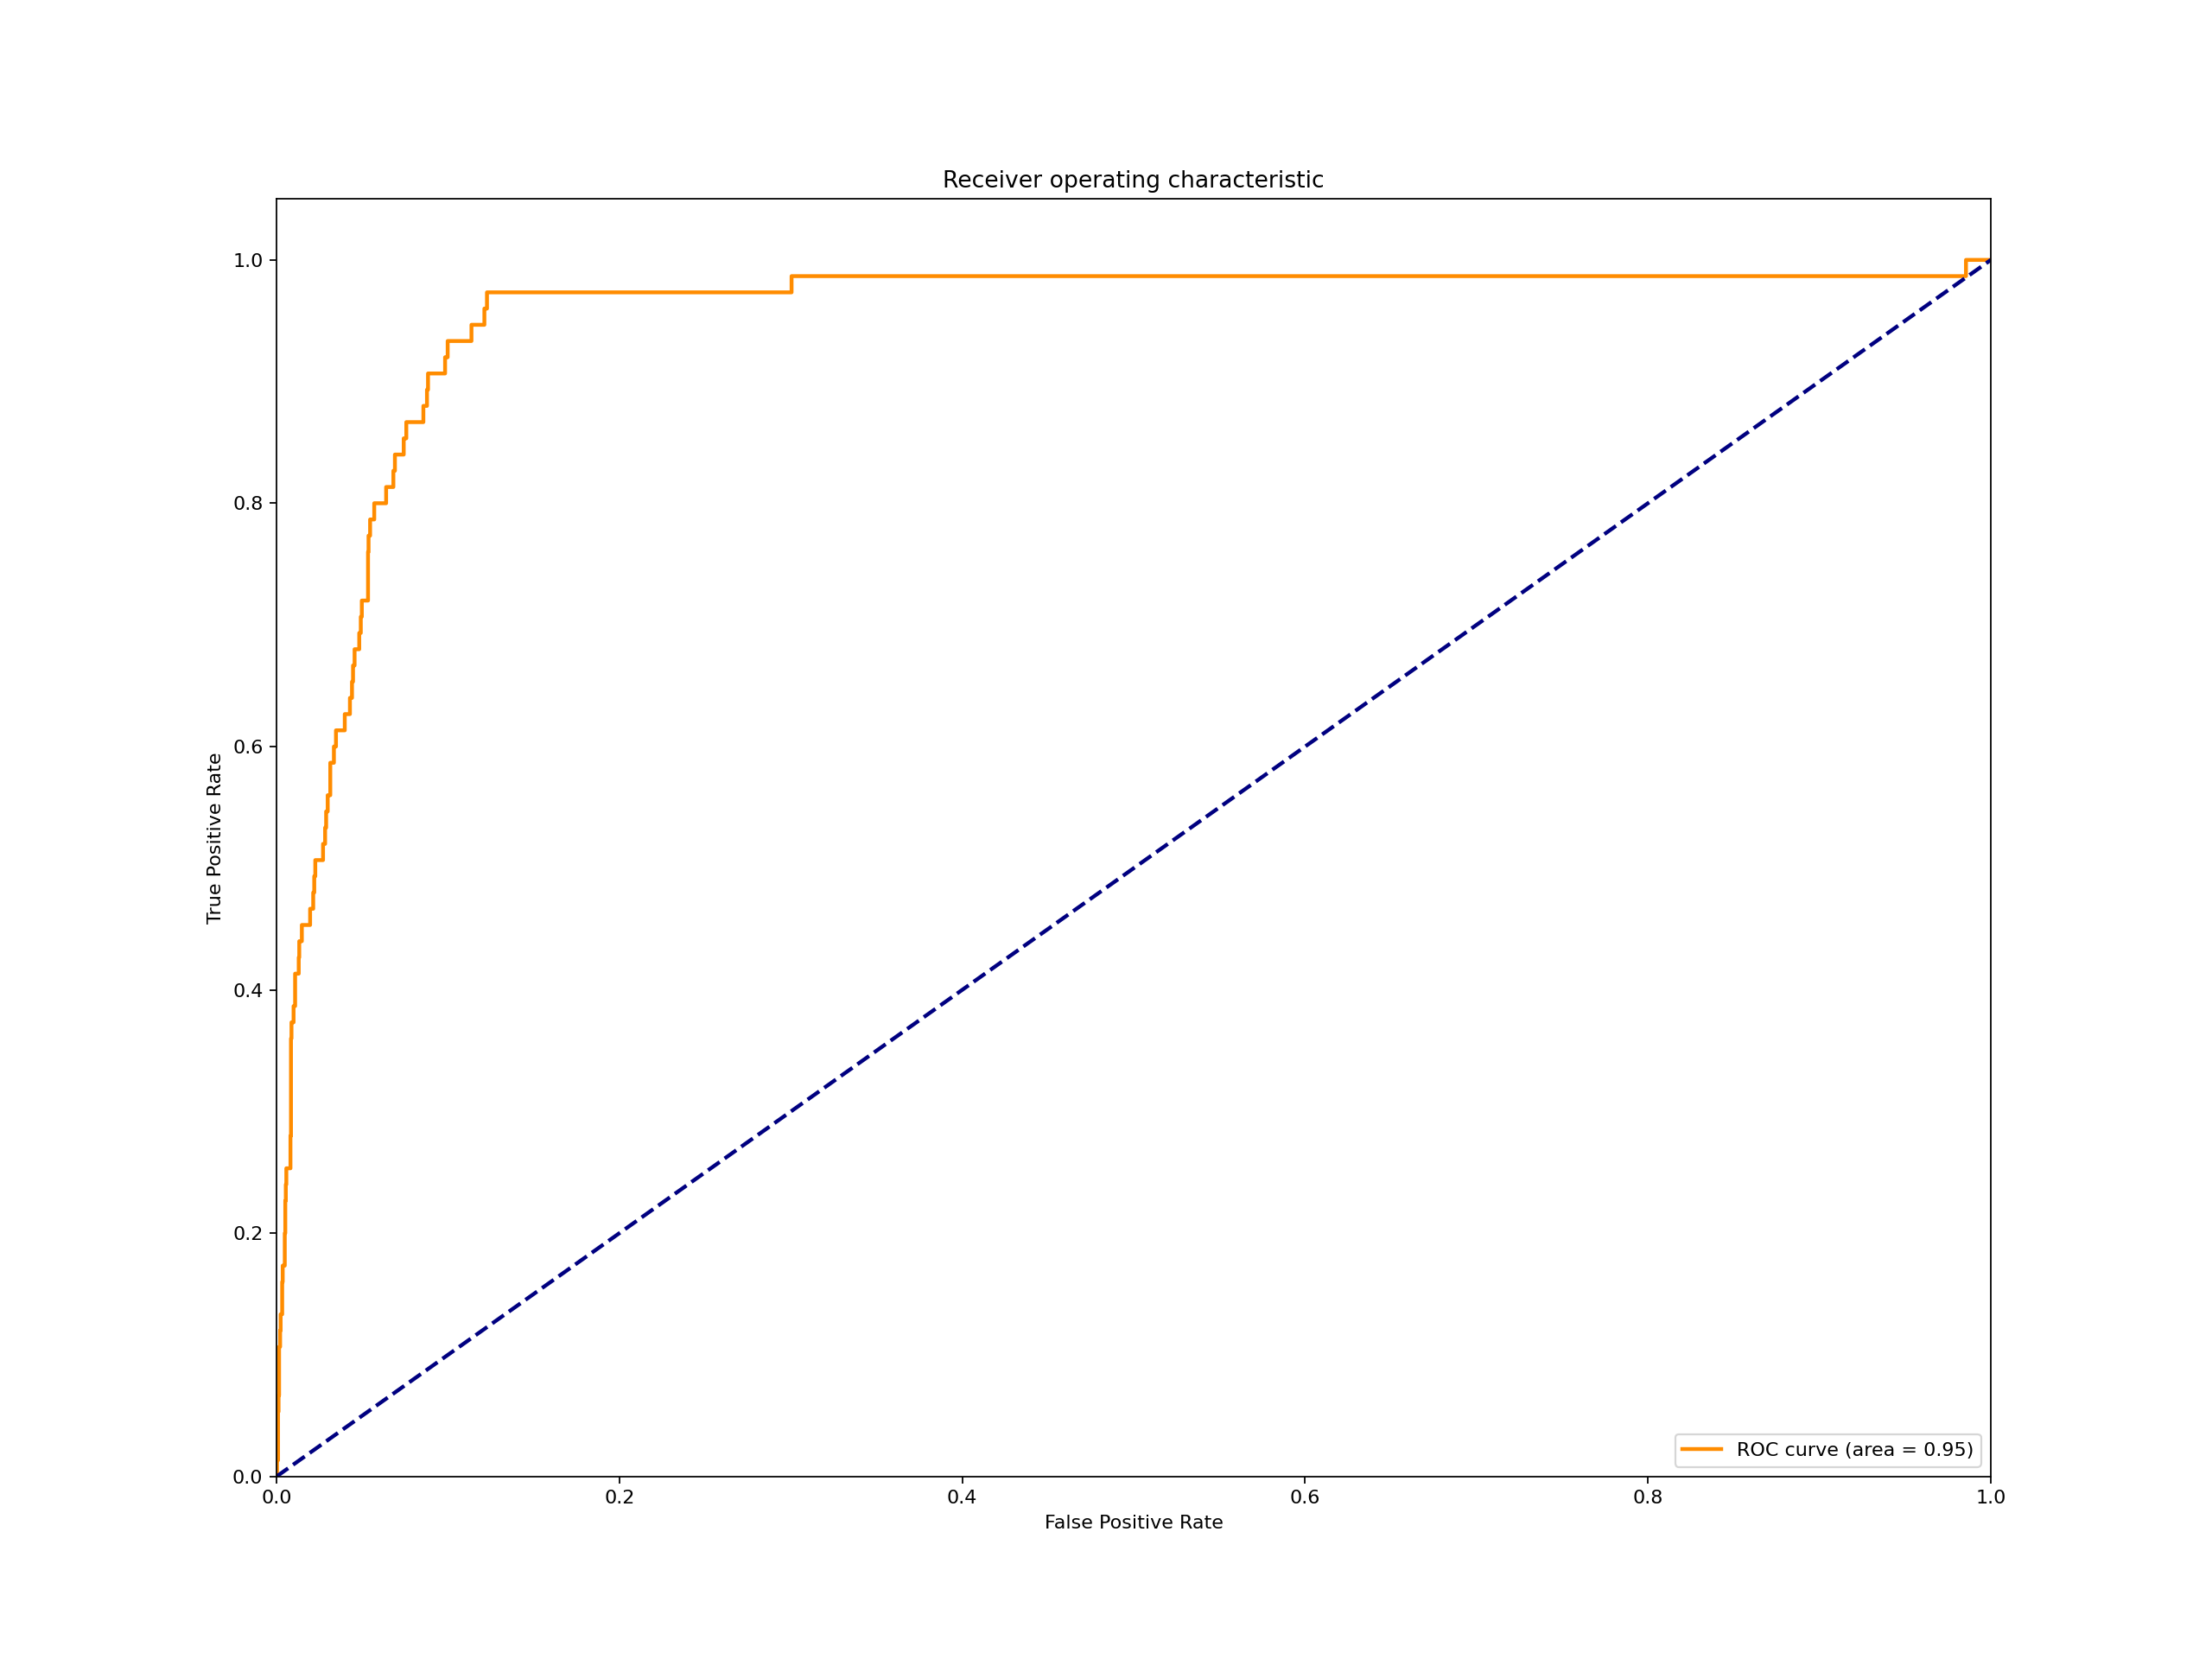

In [59]:
for mod in mods_data["RDN25-1"]:
    pos = mod[0] 
    strand = mod[1]
    find = mod[2]
    mods = mod[3]
    label_data[pos] = [0, 1]
    if tombo_data[pos][0] > 0.85:
        print(pos, tombo_data[pos][0])
    panel1.axvline(x=tombo_data[pos][0], linewidth=1, color='r')

final_prob_data = []
final_label_data = []                       
for i in range(min_pos, max_pos+1):
    final_prob_data.append(tombo_data[i])
    final_label_data.append(label_data[i])     

cm = ClassificationMetrics(pd.DataFrame(final_label_data, columns=column_names), 
                           pd.DataFrame(final_prob_data, columns=column_names), 
                           label_ids=list(range(min_pos, max_pos+1)))
cm.plot_roc("mod")


In [20]:
threshold = 0.93
peak_threshold = 0.8
ts = tombo_stats.TomboStats(IVT_vs_CBF5_GAL_and_Nop58_GAL)
for contig in ts:
    if contig[0] == "RDN25-1" and contig[1] == "+":
        all_data = contig[4]
        all_peaks = []
        in_peak = False
        peak_data = []
        min_value = 1
        for x in all_data:
            if x[0] < threshold:
                peak_data.append([x[1], x[0]])
                in_peak = True
                min_value = min(min_value, x[0])
            else:
                if in_peak and min_value < peak_threshold:
                    all_peaks.append(peak_data)
                in_peak = False
                peak_data =[]
                min_value = 1

true_mods =  [mod[0] for mod in mods_data["RDN25-1"]]
mod_found = [0 for mod in mods_data["RDN25-1"]]
mod_index = 0
has_mod = [0 for x in range(len(all_peaks))]
interval_lengths = []
for i, cluster in enumerate(all_peaks):
    interval = range(cluster[0][0], cluster[-1][0]+1)
    interval_lengths.append(len(interval))
    for j in range(len(true_mods)):
        if true_mods[j] in interval:
            mod_found[j] = 1
            has_mod[i] = 1

            
true_mods =  [mod[0] for mod in mods_data["RDN25-1"]]
prev_mod = true_mods[0]
num_clusters = 0
for x in true_mods[1:]:
#     print(x)
    if prev_mod - 5 <= x <= prev_mod + 5:
        num_clusters += 1
    prev_mod = x
    
print(num_clusters)
print(np.mean(interval_lengths), np.std(interval_lengths))
print(len(true_mods), len(all_peaks))            
print("sum(mod_found) / len(mod_found)", sum(mod_found) / len(mod_found))
print("sum(has_mod) / len(has_mod)", sum(has_mod) / len(has_mod))



24
17.86842105263158 10.270476472910563
75 38
sum(mod_found) / len(mod_found) 0.9733333333333334
sum(has_mod) / len(has_mod) 0.868421052631579


In [21]:
nanocompore = "/Users/andrewbailey/CLionProjects/personal/projects/ares_rRNA/nanocompore_analysis/out_nanocompore_results.tsv"

nanocompore_data = pd.read_csv(nanocompore, sep="\t")
nanocompore_data.columns



Index(['pos', 'chr', 'genomicPos', 'ref_id', 'strand', 'ref_kmer',
       'GMM_logit_pvalue', 'GMM_cov_type', 'GMM_n_clust', 'cluster_counts',
       'Logit_LOR'],
      dtype='object')

<IPython.core.display.Javascript object>


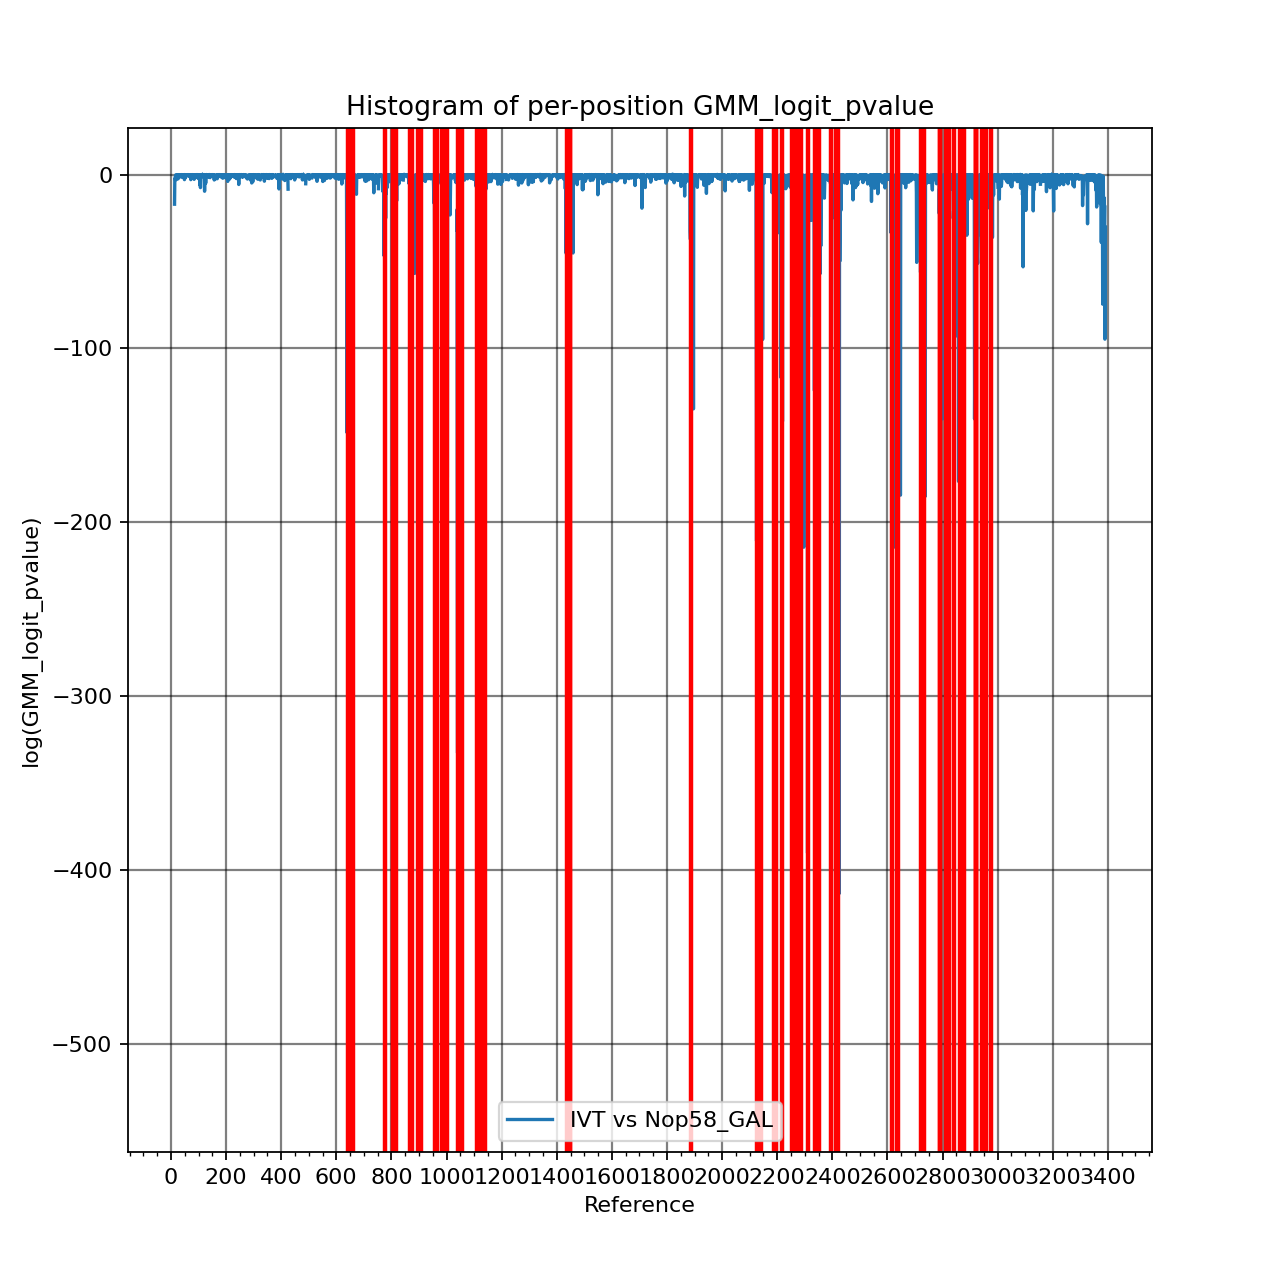

In [60]:
%matplotlib notebook
stats_files = [nanocompore]
labels = ["IVT vs Nop58_GAL"]

save_fig_path = None
contig = "RDN25-1"
title = "Histogram of per-position GMM_logit_pvalue"

fig = plt.figure(figsize=(8, 8))
panel1 = plt.axes([0.1, 0.1, .8, .8])
panel1.set_xlabel("Reference")
panel1.set_ylabel("log(GMM_logit_pvalue)")
panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)
panel1.set_title(label=title)

for i in range(len(stats_files)):
    assert os.path.exists(stats_files[i])
    nanocompore_data = pd.read_csv(nanocompore, sep="\t")
    contig_data = nanocompore_data[nanocompore_data["ref_id"]==contig]
    panel1.plot([x["pos"] for index, x in contig_data.iterrows()], [np.log(x["GMM_logit_pvalue"]) for index, x in contig_data.iterrows()], label=labels[i])

for mod in mods_data["RDN25-1"]:
    pos = mod[0]
    strand = mod[1]
    find = mod[2]
    mods = mod[3]
    panel1.axvline(x=pos, linewidth=2, color='r')
            

            
panel1.xaxis.set_major_locator(ticker.MultipleLocator(200))
panel1.xaxis.set_minor_locator(ticker.MultipleLocator(50))

panel1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

panel1.legend()

# option to save figure or just show it
if save_fig_path is not None:
    plt.savefig(save_fig_path)

/Users/andrewbailey/anaconda3/envs/signalalign/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


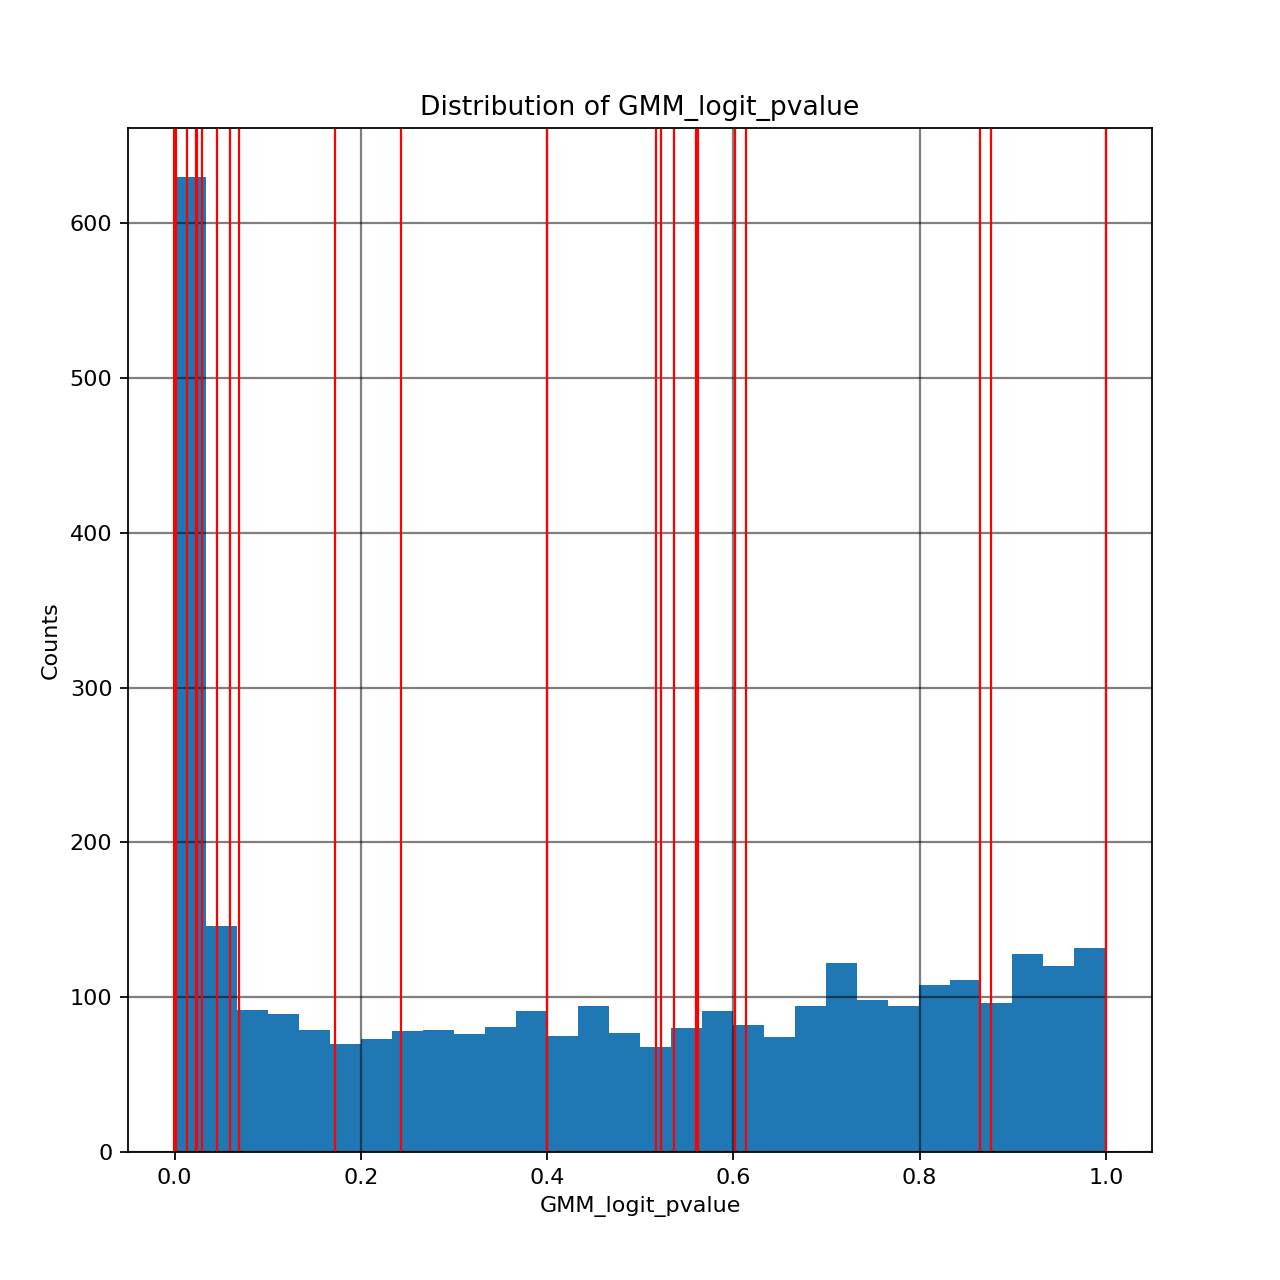

<IPython.core.display.Javascript object>


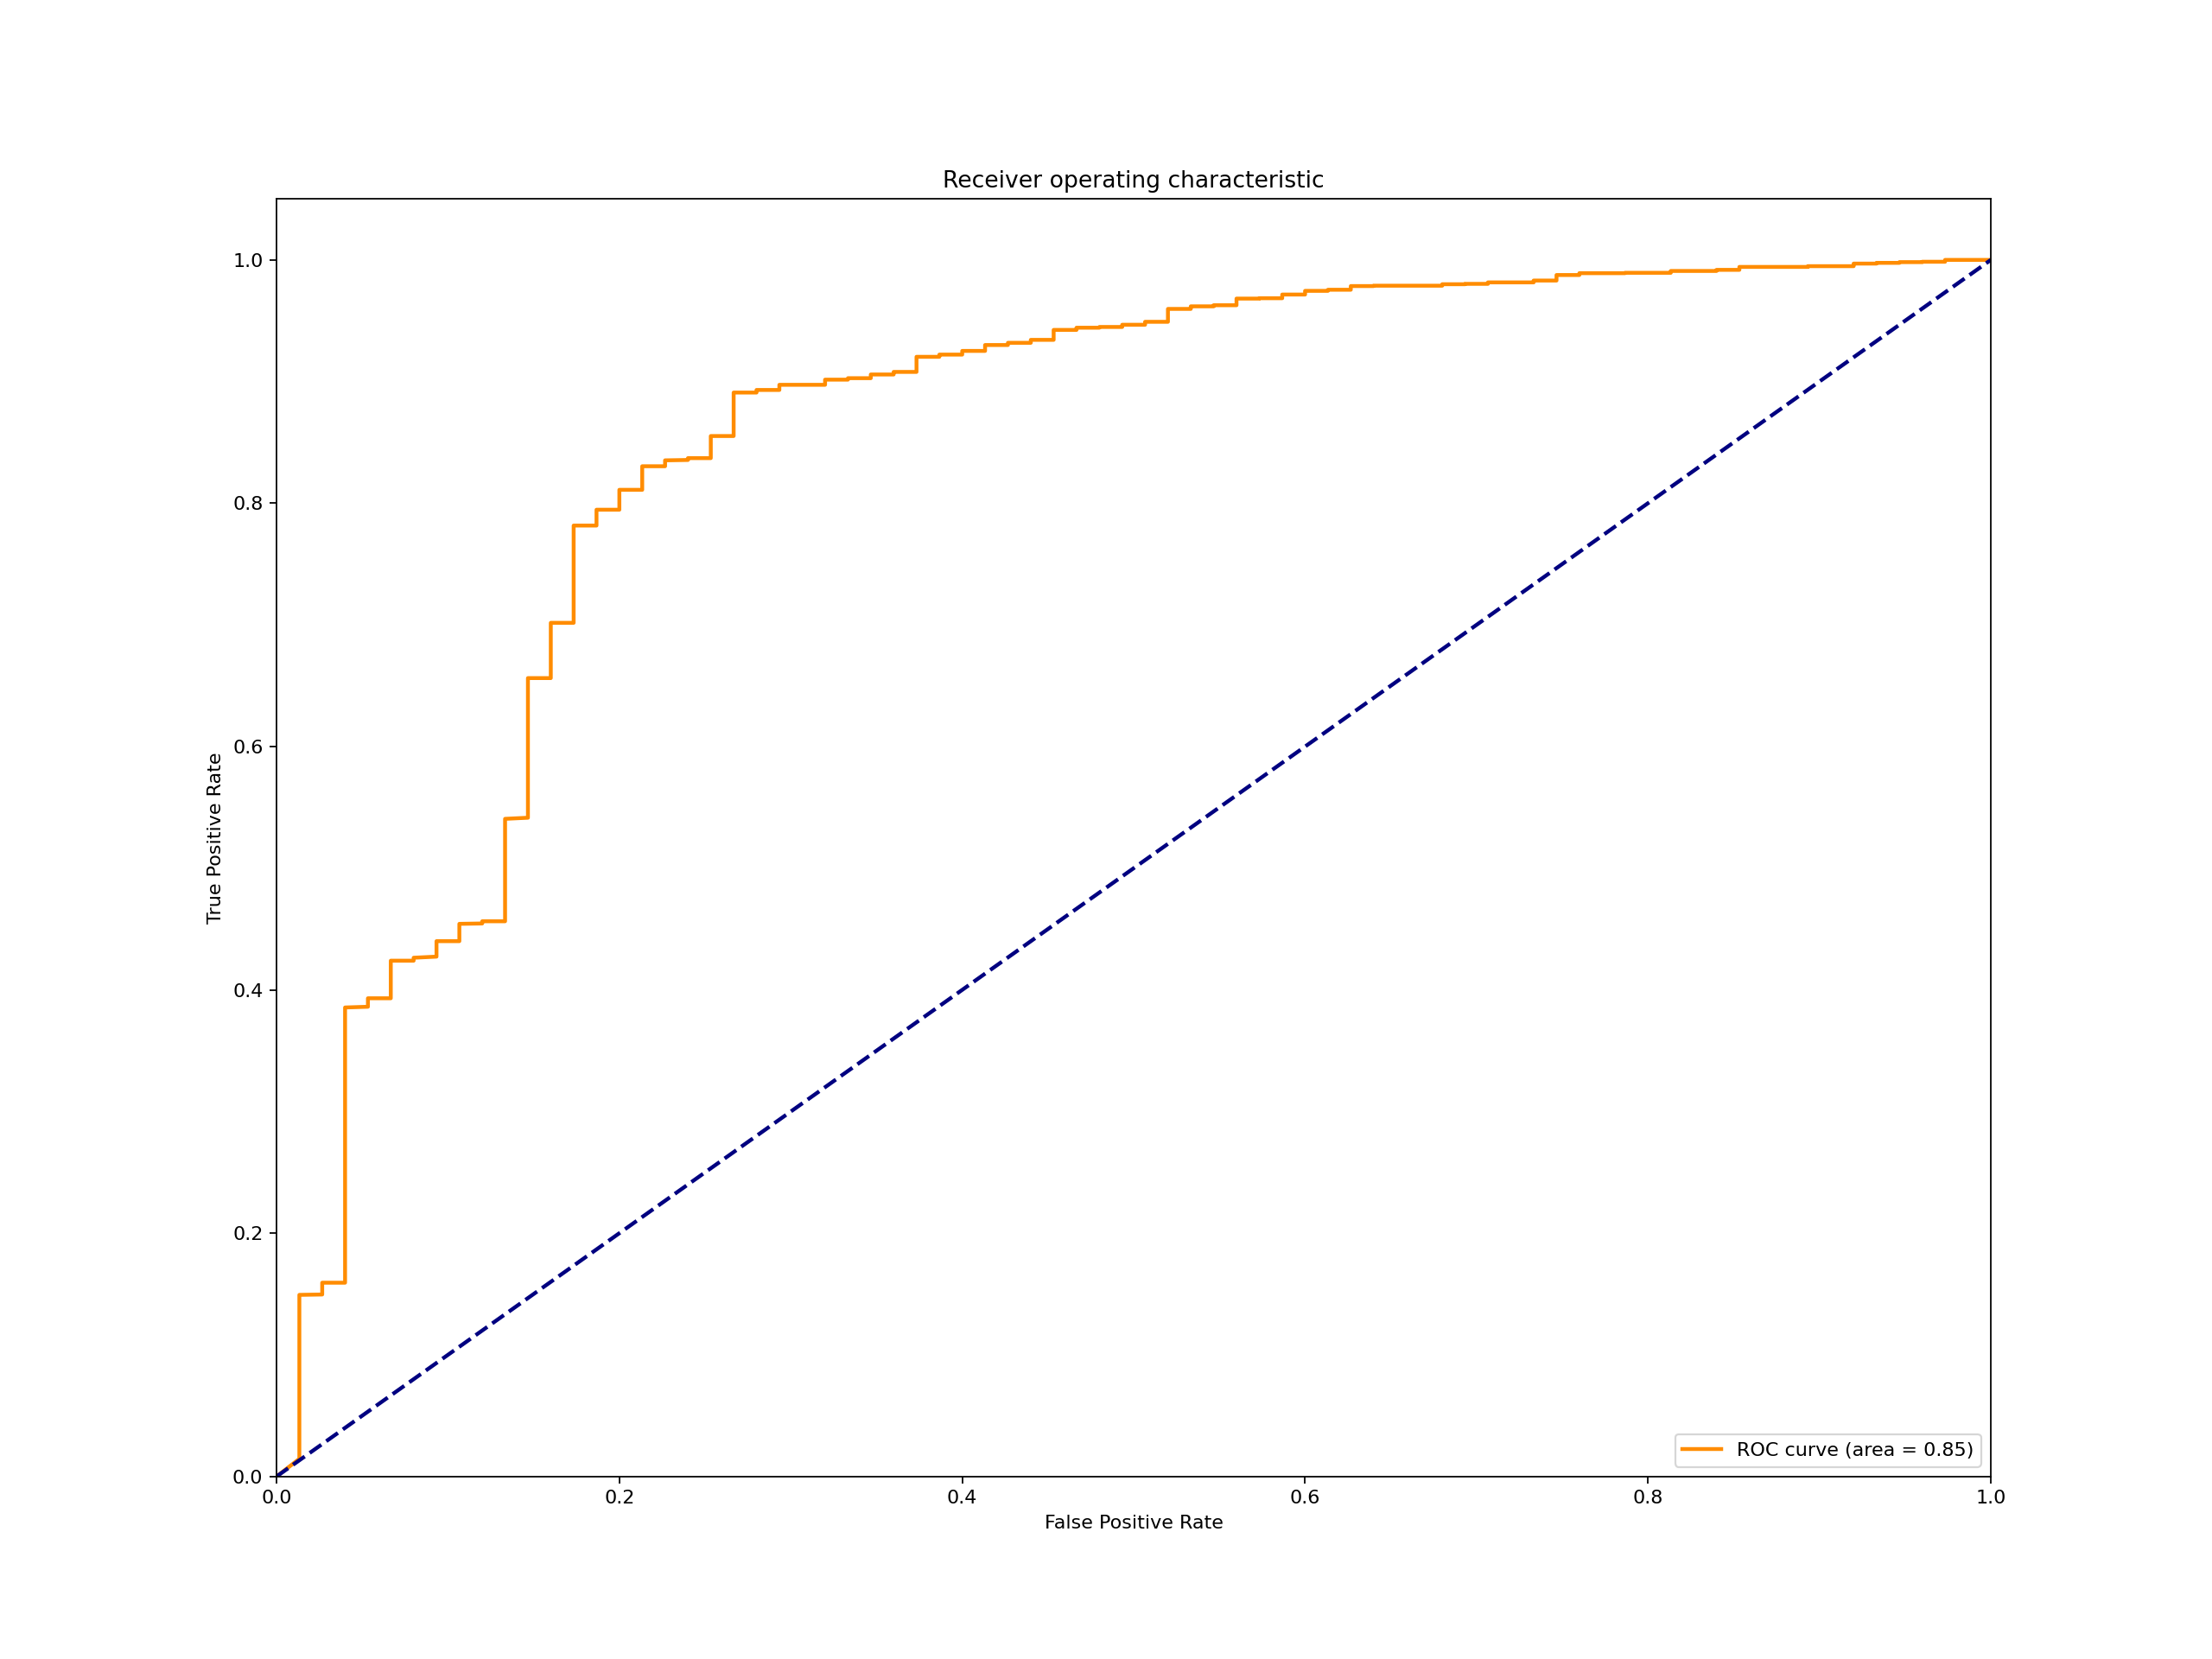

In [64]:
%matplotlib notebook

nc_data = {}
label_data = {}
probs = []
contig = "RDN25-1"

contig_data = nanocompore_data[nanocompore_data["ref_id"]==contig]
contig_data.dropna(1, "all", inplace=True)

column_names = ["unmod", "mod"]
min_pos = min(contig_data["pos"])
max_pos = max(contig_data["pos"])


for index, row in contig_data.iterrows():
    pvalue = row['GMM_logit_pvalue']
    if sum(row.isna()) > 0:
        pvalue = 1
    nc_data[row['pos']] = [pvalue, 1-pvalue]
    label_data[row['pos']] = [1, 0]
    probs.append(row['GMM_logit_pvalue'])

save_fig_path = None

title = "Distribution of GMM_logit_pvalue"

fig = plt.figure(figsize=(8, 8))
panel1 = plt.axes([0.1, 0.1, .8, .8])
panel1.set_xlabel("GMM_logit_pvalue")
panel1.set_ylabel("Counts")
panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)
panel1.set_title(label=title)
panel1.hist(probs, label="IVT vs Native", bins=30)
panel1.axvline(x=np.mean(probs)-(2*(np.std(probs))), linewidth=5, color='g')

#     kde1 = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(x)

            
for mod in mods_data["RDN25-1"]:
    pos = mod[0] 
    strand = mod[1]
    find = mod[2]
    mods = mod[3]
    label_data[pos] = [0, 1]
#     if nc_data[pos][0] > 0.85:
#         print(pos, nc_data[pos][0])
    panel1.axvline(x=nc_data[pos][0], linewidth=1, color='r')

final_prob_data = []
final_label_data = []                       
for i in sorted(list(nc_data.keys())):
    final_prob_data.append(nc_data[i])
    final_label_data.append(label_data[i])     
a = pd.DataFrame(final_label_data, columns=column_names) 
b = pd.DataFrame(final_prob_data, columns=column_names) 

cm = ClassificationMetrics(pd.DataFrame(final_label_data, columns=column_names), 
                           pd.DataFrame(final_prob_data, columns=column_names), 
                           label_ids=sorted(nc_data.keys()))
cm.plot_roc("unmod")

